# Introduction

## Problem Definition

This project addresses a **binary classification problem** focused on predicting song popularity on Spotify. The target variable `high_popularity` is derived from the original `track_popularity` metric, where:
- `high_popularity = 1` if `track_popularity > 50`
- `high_popularity = 0` if `track_popularity ≤ 50`

This binary classification approach allows for clear interpretation of what makes songs achieve above-average popularity on the platform.

## Analysis Approach

Our analysis combined several complementary methods to develop robust insights:

1. **Exploratory Data Analysis (EDA)**: Visualizing feature distributions, correlations, and genre-specific patterns to identify initial relationships between audio characteristics and popularity.

2. **Unsupervised Clustering**: Identifying natural groupings of songs based on audio features, which revealed distinct musical profiles with varying popularity rates.

3. **Predictive Modeling**: Testing multiple logistic regression formulations with increasing complexity to quantify feature relationships with popularity.

4. **Cross-Validation**: Rigorously validating model performance on unseen data to ensure our findings generalize beyond the training set.

This multi-faceted approach allowed us to triangulate findings across different analytical methods, strengthening the reliability of our conclusions.

## Key Findings Summary

After comprehensive analysis of the Spotify Songs dataset, several important patterns emerged:

1. **Genre Dominance**: Our predictive models consistently identified genre as the strongest predictor of song popularity. Pop and rock genres showed the highest positive coefficients across all models, with pop songs having approximately 1.24 times higher odds of achieving high popularity compared to the reference category.

2. **Audio Feature Significance**: Through both ANOVA testing across clusters and logistic regression modeling, specific audio characteristics showed significant influence on popularity:
   - **Instrumentalness**: Strong negative relationship with popularity (coefficient -0.22), confirming that vocal-focused songs tend to be more popular than instrumental tracks
   - **Loudness**: Positive relationship with popularity (coefficient 0.29), indicating that professionally produced, louder tracks generally achieve higher popularity
   - **Energy**: Surprisingly showed a negative relationship (-0.16) when controlling for other factors, suggesting that extremely high-energy songs may be less broadly appealing

3. **Genre-Specific Audio Profiles**: Our highest-performing model revealed that audio features impact popularity differently across genres:
   - Danceability is particularly important for popularity in rap (0.33) and pop (0.19) genres
   - Energy has varying effects, particularly negative for r&b tracks (-0.34)
   - Instrumentalness, while generally negative, shows positive effects for rap (0.23) and rock (0.11) when these genres specifically feature instrumental elements

4. **Non-Linear Feature Relationships**: Our prediction visualizations revealed important non-linear patterns:
   - Loudness shows a threshold effect where increases below -20 dB have minimal impact on popularity
   - The steepest increase in popularity probability occurs in the mid-to-high loudness range (-10 to -5 dB)
   - Genre significantly modifies these relationships, with pop and rock songs crossing the popularity threshold at lower loudness values

5. **Feature Interaction Importance**: Our prediction grid demonstrates that:
   - The impact of loudness on popularity varies substantially by genre and instrumentalness level
   - Pop songs maintain relatively high popularity probabilities even at higher instrumentalness levels
   - Rock songs show a unique tolerance for instrumental elements compared to other genres
   - Context-specific recommendations would be necessary, as the same audio feature adjustments produce different effects across genres

6. **Cluster Analysis Alignment**: The five clusters identified in our analysis showed distinct popularity profiles that aligned with our modeling results:
   - Clusters dominated by pop and rap genres showed higher popularity rates
   - Clusters characterized by extreme audio feature values (very high instrumentalness or very low energy) showed lower popularity rates
   - The "High Energy Dance Tracks" cluster (high danceability, moderate-high energy) aligned with the positive interactions between genre and danceability found in our best model

7. **Model Performance Validation**: Cross-validation confirmed that our interaction-based model (Model 6) generalized well to unseen data, maintaining an AUC of 0.671 compared to 0.675 on the training set. This minimal difference between training and validation performance demonstrates the robustness of our findings.

8. **Model Performance Limitations**: Even our best-performing model achieved modest predictive power (ROC AUC = 0.675), suggesting that while audio features and genre provide significant signal, other external factors like artist fame, marketing, and cultural trends likely play important roles in determining song popularity.

## EDA and Modeling Alignment

Our exploratory analysis revealed several patterns that were later confirmed and quantified by our predictive models:

1. The EDA histograms showed higher popularity rates for songs with moderate-to-high danceability (0.6-0.8) and conventional loudness levels (-7dB), which aligned with the positive coefficients for these features in our regression models.

2. The correlation analysis revealed a strong relationship between energy and loudness (0.68), which helped us interpret the seemingly contradictory coefficients for these features in our models (negative for energy, positive for loudness).

3. The genre popularity bar chart identified pop as having the highest proportion of popular songs (approximately 50%), which was confirmed by the large positive coefficient for pop genre in our models.

## Skills Developed

This project enhanced several valuable data science skills:

1. **Preprocessing and Feature Engineering**: Transforming skewed variables, standardizing features, and creating derived features (like polynomial terms and interaction effects) to improve model performance.

2. **Model Evaluation and Selection**: Systematically evaluating multiple model formulations to find the optimal complexity level, using appropriate metrics (ROC AUC, accuracy) to compare classification models.

3. **Handling Complex Interactions**: Recognizing and interpreting interaction effects between categorical and continuous variables, which revealed how features' impacts vary across contexts.

4. **Visualizing Predictive Relationships**: Creating multi-dimensional visualization grids to understand how multiple features interact to influence predictions, revealing non-linear relationships and decision boundaries.

5. **Clustering for Pattern Discovery**: Using unsupervised learning to identify natural groupings in the data, which provided insights that informed subsequent supervised modeling.

6. **Statistical Interpretation**: Moving beyond simple correlations to understand the conditional relationships between variables when controlling for other factors.

7. **Cross-Validation Implementation**: Properly implementing stratified k-fold cross-validation with appropriate preprocessing to ensure reliable model evaluation and selection.

These skills are broadly applicable to many predictive modeling scenarios, particularly when analyzing behavior or preferences that vary across different categories or contexts, such as consumer preferences, healthcare outcomes, or financial behaviors.


# Data Preparation To Display EDA & Clustering Highlights

In [34]:
# Data Preparation for Final Project Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)

# Load the data
data_url = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv'
df = pd.read_csv(data_url)

print(f"Dataset dimensions: {df.shape[0]} rows and {df.shape[1]} columns")

# Check for duplicate tracks
print(f"Total rows in dataset: {df.shape[0]}")
print(f"Unique track_ids: {df['track_id'].nunique()}")
print(f"Number of tracks that appear multiple times: {df.shape[0] - df['track_id'].nunique()}")

# Create a deduplicated dataset by keeping only the first occurrence of each track
df_unique = df.drop_duplicates(subset=['track_id'])
print(f"Deduplicated dataset shape: {df_unique.shape}")

# Create binary popularity target
popularity_threshold = 50
df_unique['high_popularity'] = (df_unique['track_popularity'] > popularity_threshold).astype(int)
print(f"Proportion of high popularity songs: {df_unique['high_popularity'].mean():.2f}")

# Identify features for analysis
categorical_cols = ['playlist_genre', 'playlist_subgenre', 'key', 'mode']
id_cols = ['track_id', 'track_album_id', 'playlist_id']
text_cols = ['track_name', 'track_artist', 'track_album_name', 'playlist_name']
date_cols = ['track_album_release_date']

# Define continuous audio features for clustering and modeling
cluster_features = ['danceability', 'energy', 'loudness', 'speechiness',
                    'acousticness', 'instrumentalness', 'liveness',
                    'valence', 'tempo']

# Create standardized features for clustering
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_unique[cluster_features])

# Determine optimal number of clusters with elbow method
wcss = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Calculate silhouette scores
silhouette_scores = []
for k in range(2, 11):  # Silhouette requires at least 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(df_scaled)
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Set optimal k based on elbow method and silhouette scores
optimal_k = 5  # Based on elbow method and silhouette analysis

# Apply K-means with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_unique['cluster'] = kmeans.fit_predict(df_scaled)

# Apply PCA for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['cluster'] = df_unique['cluster']
pca_df['high_popularity'] = df_unique['high_popularity']

# Create a feature list for visualizations that includes track_popularity
features = ['danceability', 'energy', 'loudness', 'acousticness', 'valence', 'tempo']

print("Data preparation complete. Ready for visualization and analysis.")

Dataset dimensions: 32833 rows and 23 columns
Total rows in dataset: 32833
Unique track_ids: 28356
Number of tracks that appear multiple times: 4477
Deduplicated dataset shape: (28356, 23)
Proportion of high popularity songs: 0.37
Data preparation complete. Ready for visualization and analysis.


# EDA Highlights
Key visualizations and insights

## Key Feature Distributions

The histograms reveal important patterns in the audio characteristics of Spotify songs:

1. **Danceability** shows a right-skewed distribution, with high-popularity songs (pink) more prevalent in the higher danceability range (0.6-0.8).

2. **Energy** displays a bimodal distribution with peaks around 0.3 and 0.7, suggesting distinct groups of low and high-energy tracks. High-popularity songs dominate in the 0.6-0.8 energy range.

3. **Loudness** follows a roughly normal distribution centered around -7dB. Notably, very quiet songs (below -10dB) rarely achieve high popularity.

4. **Acousticness** exhibits a J-shaped distribution with most songs having either very low or high acousticness, demonstrating the polarized nature of production styles on Spotify.

5. **Valence** (musical positiveness) shows a relatively uniform distribution across the range, with a slight prevalence of high-popularity songs in the mid-to-high valence range.

6. **Tempo** displays a normal-like distribution centered around 120 BPM, with high-popularity songs relatively evenly distributed across different tempos.

These distributions highlight that certain ranges of audio features are associated with higher popularity, particularly moderate-to-high values of danceability and energy combined with conventional loudness levels.

### Distribution of Key Audio Features

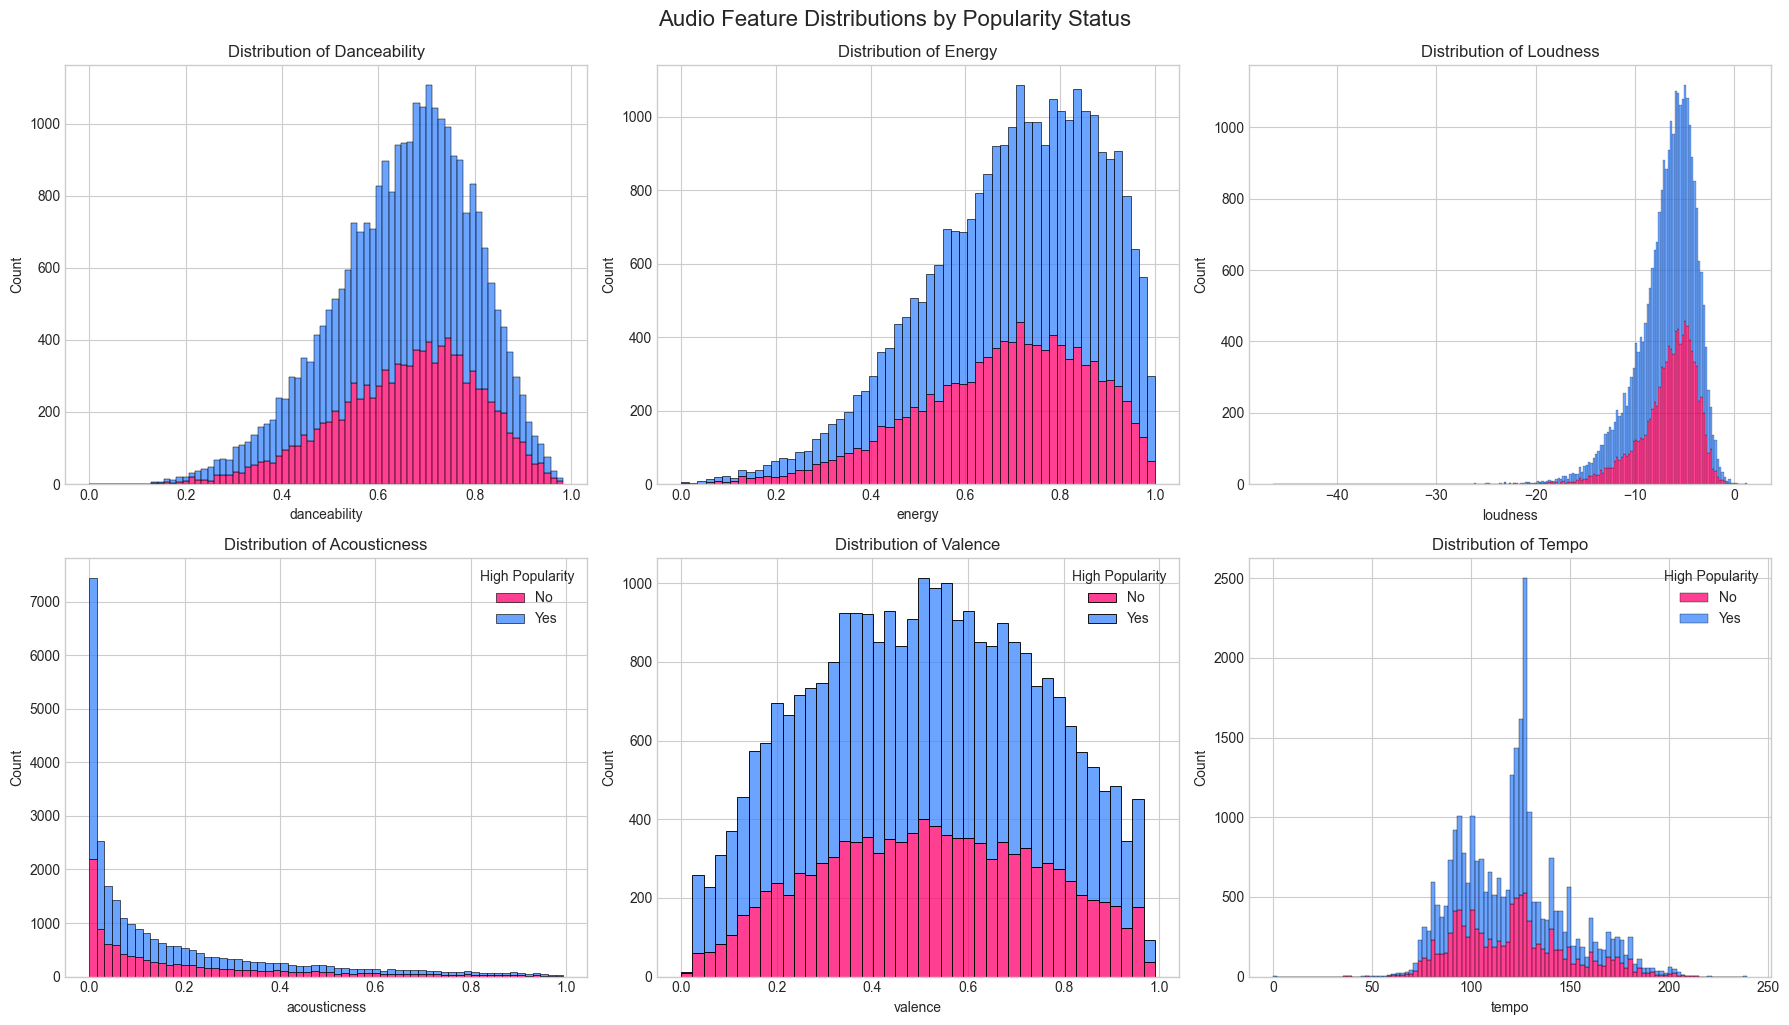

In [35]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot distributions colored by popularity
features = ['danceability', 'energy', 'loudness', 'acousticness', 'valence', 'tempo']
for i, feature in enumerate(features):
    sns.histplot(data=df_unique, x=feature, hue='high_popularity',
                 multiple="stack", palette=['#3A86FF', '#FF006E'], ax=axes[i])
    axes[i].set_title(f'Distribution of {feature.capitalize()}', fontsize=12)
    if i >= 3:  # Only add legend to bottom row
        axes[i].legend(title='High Popularity', labels=['No', 'Yes'])
    else:
        axes[i].get_legend().remove()

plt.tight_layout()
plt.suptitle('Audio Feature Distributions by Popularity Status', fontsize=16, y=1.02)
plt.show()

## Feature Relationships

The correlation analysis and scatter plots reveal important relationships between audio features:

1. **Correlation Matrix**: The strongest correlations exist between energy and loudness (0.68), confirming that energetic songs are typically produced at higher volume levels. Interestingly, direct correlations between individual audio features and track popularity are relatively weak: danceability (0.047), energy (-0.10), loudness (0.037), acousticness (0.092), and valence (0.023). These weak correlations suggest that popularity depends on complex combinations of features rather than any single characteristic.

2. **Danceability vs. Energy**: While high-popularity songs (pink) appear throughout the feature space, there is a slight concentration in regions of moderate-to-high danceability combined with varying energy levels. The wide distribution suggests that different combinations can lead to popularity, likely influenced by genre-specific preferences.

3. **Acousticness vs. Valence**: Popular songs exist across the entire acousticness-valence space, with no strong pattern of exclusion in any region. This indicates that both acoustic and electronic production styles can achieve popularity, and that emotional tone (valence) alone is not strongly predictive of popularity.

4. **Loudness vs. Energy**: The scatter plot confirms a strong positive relationship between loudness and energy, with songs following a clear diagonal pattern. Both high and low popularity songs follow this natural production relationship, suggesting it's more a characteristic of music production than a driver of popularity.

5. **Instrumentalness vs. Danceability**: The data points are distributed across all instrumentalness values, though with higher density at lower instrumentalness levels. This suggests that while vocal-focused tracks are more common overall in the dataset, instrumental tracks can still achieve popularity when combined with appropriate other characteristics.

These relationships demonstrate that song popularity is influenced by specific combinations of audio features rather than individual characteristics in isolation, and that these combinations likely vary by genre and audience preferences. The relatively weak direct correlations highlight the need for multivariate and context-specific analysis when predicting song popularity.


### Correlation Heatmap and Feature Relationships

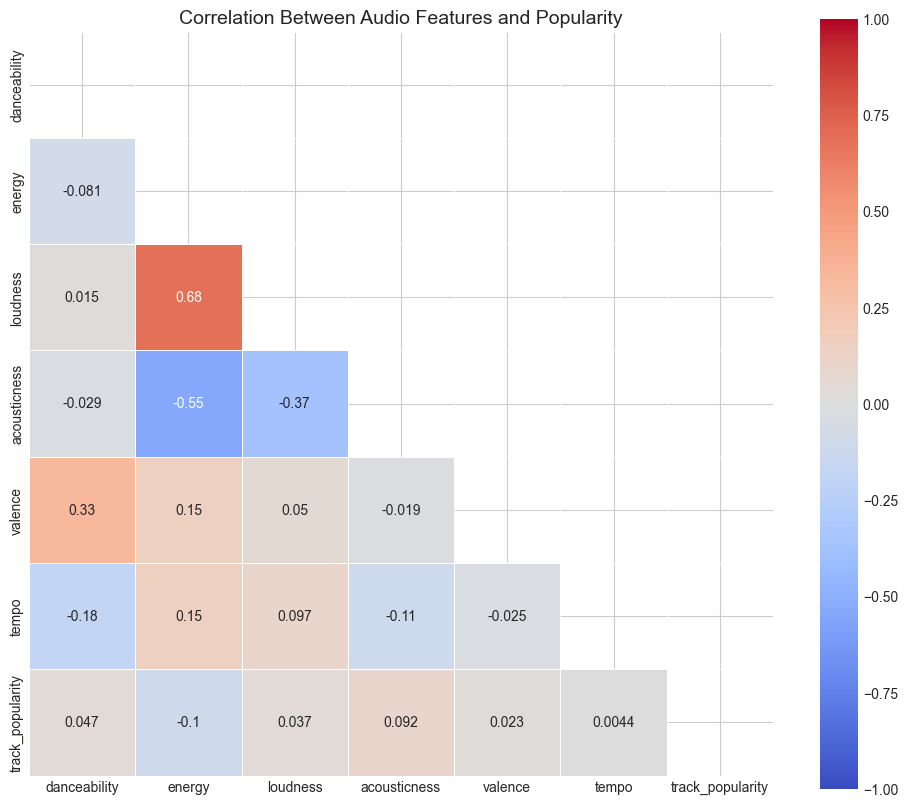

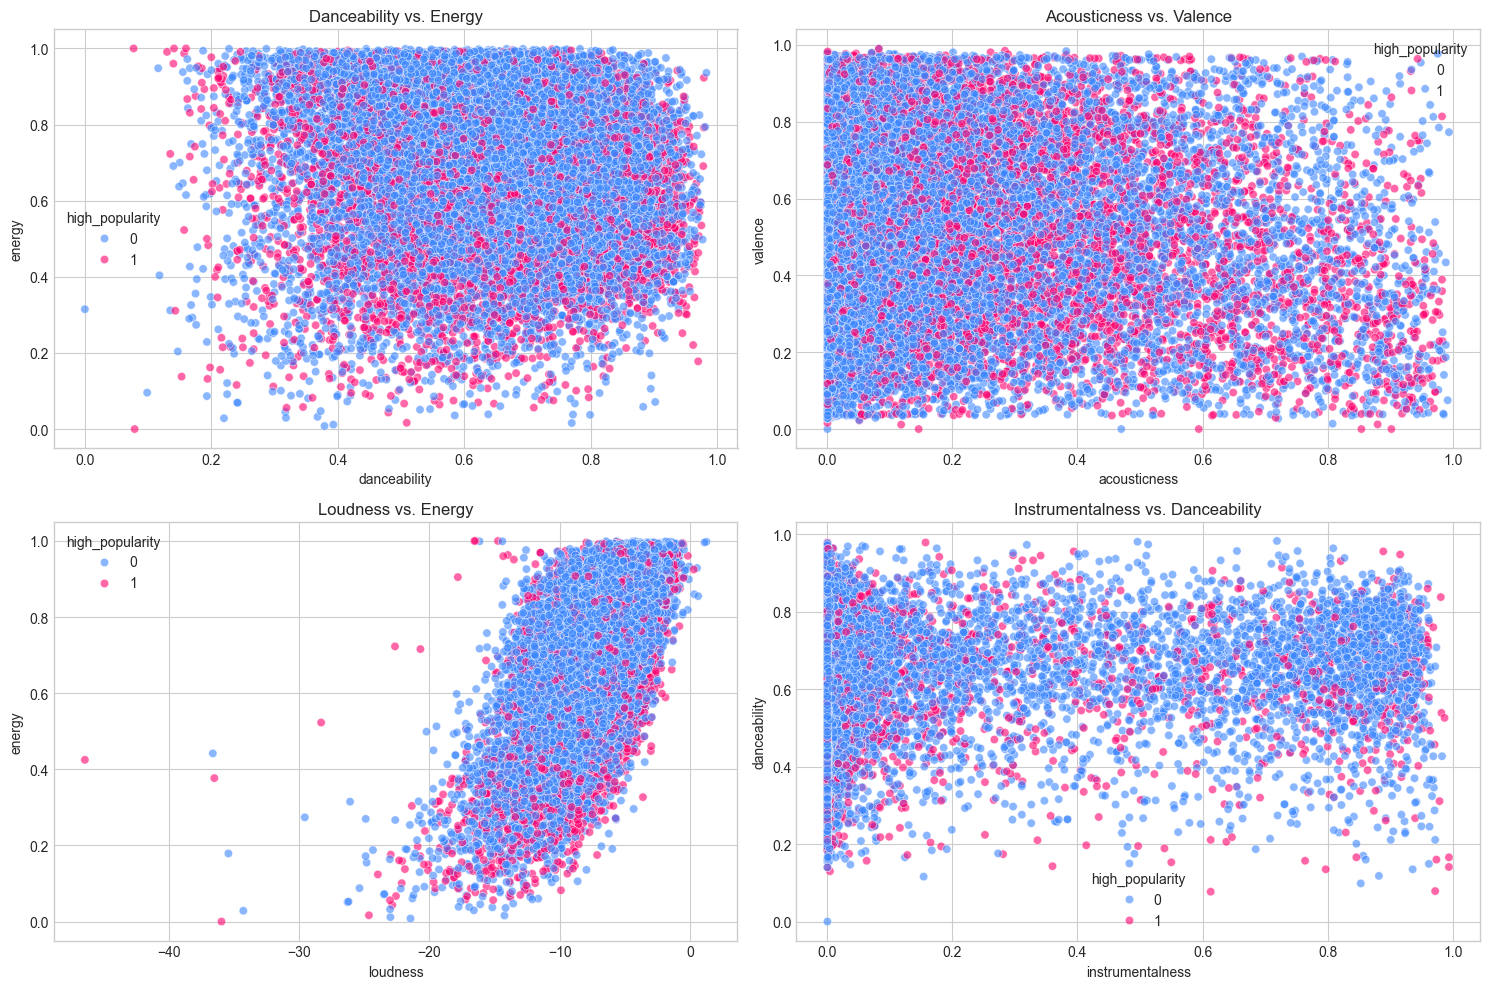

In [36]:
plt.figure(figsize=(12, 10))
correlation = df_unique[features + ['track_popularity']].corr()
mask = np.triu(correlation)
sns.heatmap(correlation, annot=True, cmap='coolwarm', mask=mask,
            vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
plt.title('Correlation Between Audio Features and Popularity', fontsize=14)
plt.show()

# Scatter plot of key relationships
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.scatterplot(data=df_unique, x='danceability', y='energy',
                hue='high_popularity', palette=['#3A86FF', '#FF006E'], alpha=0.6)
plt.title('Danceability vs. Energy')

plt.subplot(2, 2, 2)
sns.scatterplot(data=df_unique, x='acousticness', y='valence',
                hue='high_popularity', palette=['#3A86FF', '#FF006E'], alpha=0.6)
plt.title('Acousticness vs. Valence')

plt.subplot(2, 2, 3)
sns.scatterplot(data=df_unique, x='loudness', y='energy',
                hue='high_popularity', palette=['#3A86FF', '#FF006E'], alpha=0.6)
plt.title('Loudness vs. Energy')

plt.subplot(2, 2, 4)
sns.scatterplot(data=df_unique, x='instrumentalness', y='danceability',
                hue='high_popularity', palette=['#3A86FF', '#FF006E'], alpha=0.6)
plt.title('Instrumentalness vs. Danceability')

plt.tight_layout()
plt.show()

Your Genre Analysis needs some adjustment to accurately reflect what's shown in the charts. Here's a revised version that aligns better with the visualizations:

## Genre Analysis

The genre analysis provides crucial context for understanding popularity patterns:

1. **Popularity by Genre**: The bar chart shows pop has the highest proportion of popular songs (approximately 50%), followed by rap, rock, and latin (all around 40-41%). R&B shows a lower rate (around 32%), while EDM has the lowest popularity rate (approximately 17%). These differences suggest genre-specific popularity dynamics on Spotify.

2. **Audio Profiles by Genre**:
   - **Pop**: Characterized by moderate danceability (median ~0.65), moderate-to-high energy (median ~0.7), low acousticness (median ~0.2), and very low instrumentalness, creating a vocal-driven sound profile.
   - **Rap**: Shows high danceability (median ~0.7-0.8), moderate energy (median ~0.65), low acousticness, and very low instrumentalness, emphasizing rhythm and vocals.
   - **Rock**: Displays lower danceability (median ~0.5) with higher energy (median ~0.8) and variable acousticness, reflecting diverse subgenres.
   - **R&B**: Features moderate danceability (median ~0.65-0.7) and moderate energy (median ~0.55) with higher acousticness (median ~0.3-0.4).
   - **Latin**: Exhibits high danceability (median ~0.75) and moderate energy (median ~0.7-0.8).
   - **EDM**: Shows the highest energy (median ~0.85), moderate danceability (median ~0.65), lowest acousticness, and notably higher instrumentalness than other genres.

3. **Genre-Feature Interaction**: The box plots reveal that while genres have distinct audio profiles, no single feature perfectly predicts popularity. Pop and rap (higher popularity genres) share moderately high danceability and low instrumentalness, but rock (also relatively popular in this dataset) has lower danceability. This suggests that popularity prediction requires considering both genre context and the specific audio features that matter within each genre.

This analysis demonstrates that genre provides an important framework for interpreting audio feature effects on popularity, with distinct audio profiles associated with different genre categories. The relationship between audio features and popularity is often genre-specific rather than universal across all music.


### Popularity by Genre

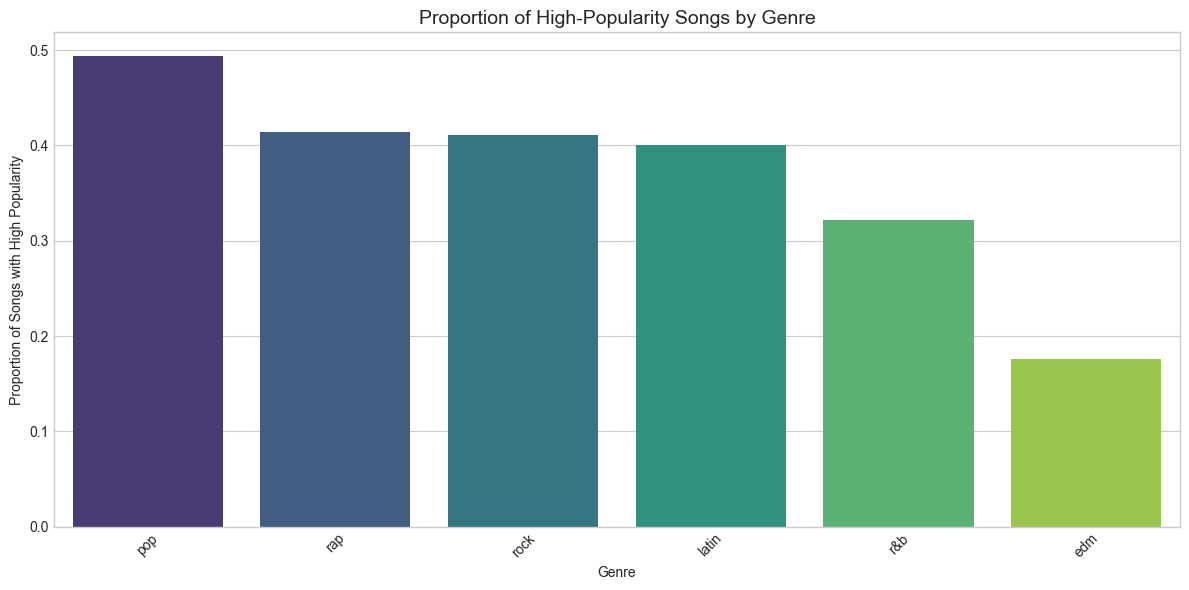

In [37]:
plt.figure(figsize=(12, 6))
genre_pop = df_unique.groupby('playlist_genre')['high_popularity'].mean().sort_values(ascending=False)
sns.barplot(x=genre_pop.index, y=genre_pop.values, palette='viridis')
plt.title('Proportion of High-Popularity Songs by Genre', fontsize=14)
plt.ylabel('Proportion of Songs with High Popularity')
plt.xlabel('Genre')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Feature Distribution by Genre

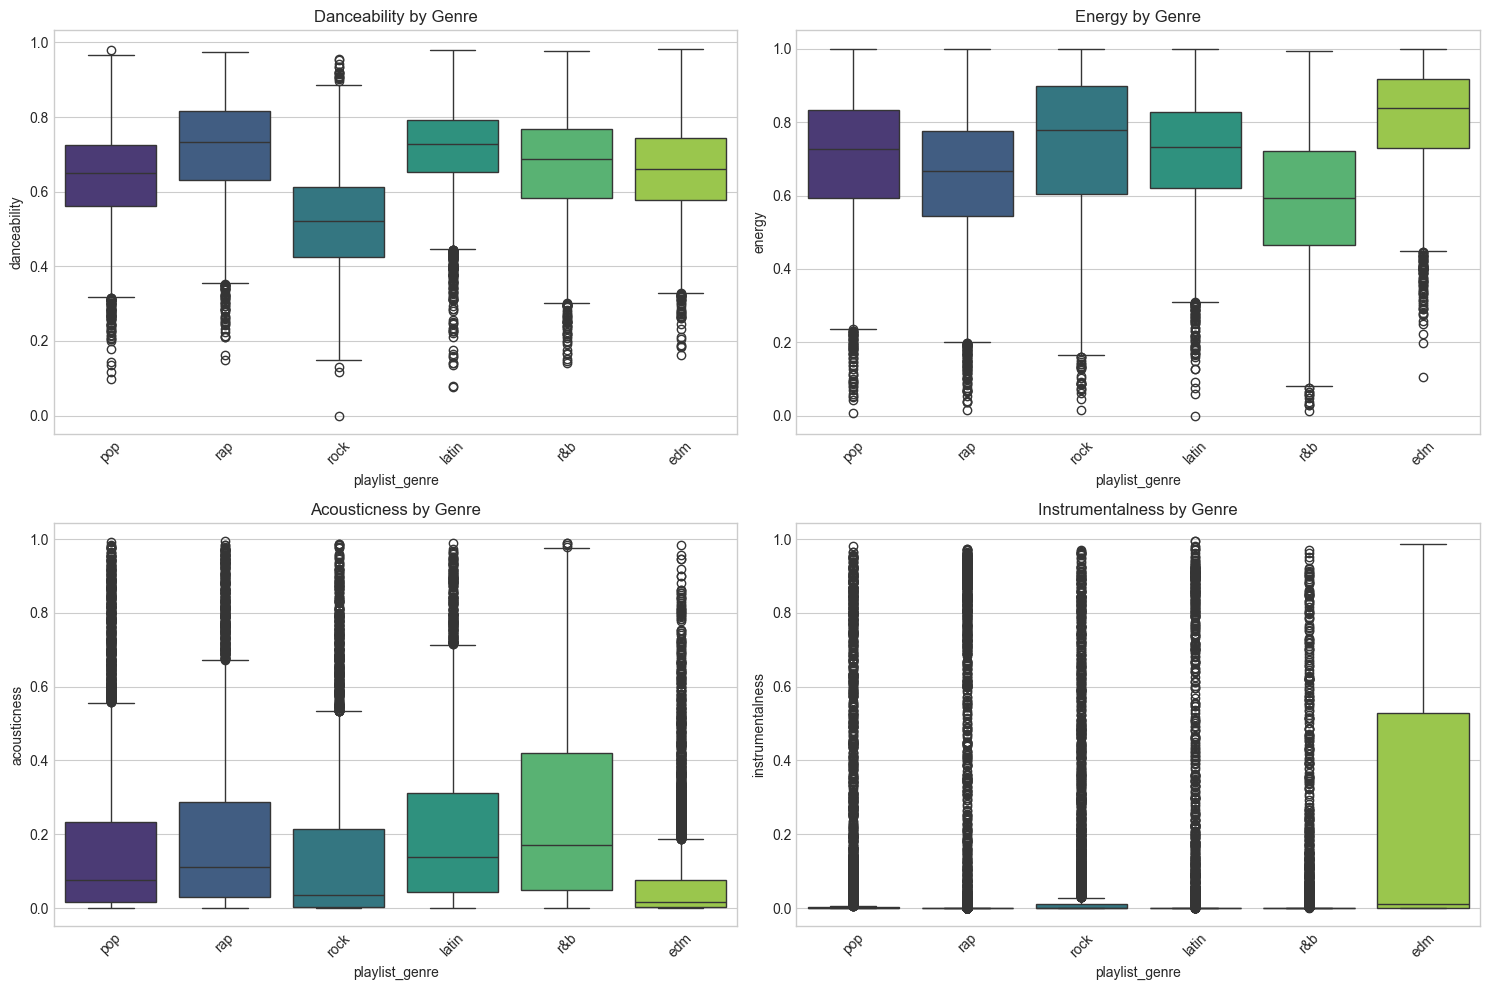

In [38]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(['danceability', 'energy', 'acousticness', 'instrumentalness']):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='playlist_genre', y=feature, data=df_unique, palette='viridis')
    plt.title(f'{feature.capitalize()} by Genre')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Clustering Results Visualization & Interpretation
Optimal clusters and interpretations

## Implications for Modeling

The clustering analysis provides several key insights that will inform our predictive modeling approach:

1. **Feature Importance**: Based on the F-statistics from ANOVA and cluster profiles, we should pay particular attention to instrumentalness, speechiness, energy, and acousticness as potentially strong predictors of popularity.

2. **Interaction Effects**: The distinct cluster profiles suggest important interactions between features. For example, high danceability appears more beneficial for popularity when combined with moderate-to-high energy levels (Clusters 1 and 2).

3. **Genre Considerations**: The strong association between clusters and genres indicates that genre should be included in our models, potentially interacting with audio features to capture genre-specific effects on popularity.

4. **Non-Linear Relationships**: The complex relationship between audio features and popularity suggests we should consider non-linear transformations or polynomial terms for certain features. For instance, very high or very low values of energy might have different effects on popularity.

5. **Feature Engineering**: Based on the cluster profiles, we might benefit from creating new features that capture the distance of a song from the centroid of high-popularity clusters (1 and 2) in the audio feature space.

6. **Classification Boundary**: The clear separation between clusters with different popularity rates suggests that a logistic regression model with properly selected features may perform well in distinguishing high-popularity from low-popularity songs.

These insights will guide our model formulation, particularly in selecting which interaction terms and non-linear transformations to include in our predictive models.

## Optimat Cluster Selection (Elbow Plot)

The elbow method helps identify the optimal number of clusters for our song dataset:

1. **WCSS Decline**: The Within-Cluster Sum of Squares (WCSS) shows a sharp decline from 1 to 5 clusters, followed by a more gradual decrease beyond that point.

2. **Elbow Point**: The curve forms a distinct "elbow" at k=5, indicating that additional clusters beyond this point provide diminishing returns in terms of explained variance.

3. **Optimal Choice**: Five clusters were selected as the optimal number, balancing model complexity with effective segmentation of the Spotify songs dataset.

This selection is further supported by silhouette analysis, which showed the highest average silhouette score at k=5, indicating good separation and cohesion within the clusters.

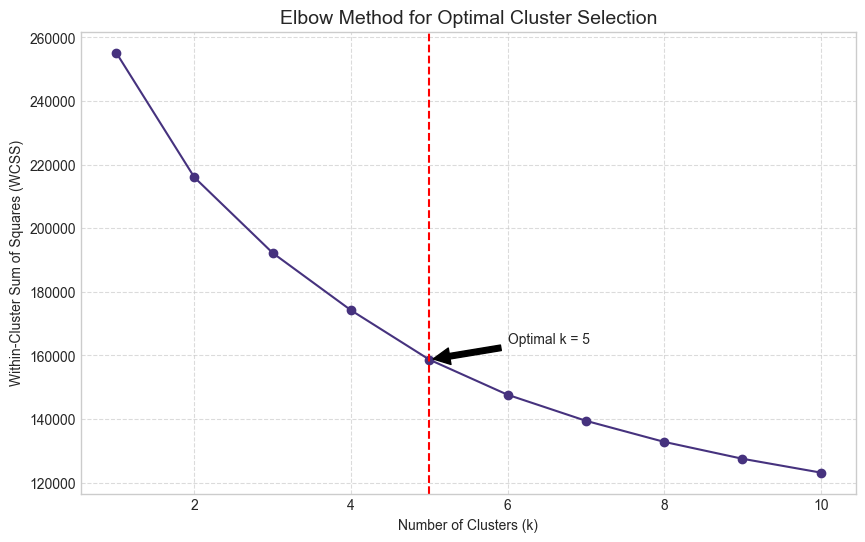

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='-')
plt.axvline(x=optimal_k, color='red', linestyle='--')
plt.title('Elbow Method for Optimal Cluster Selection', fontsize=14)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.annotate(f'Optimal k = {optimal_k}',
             xy=(optimal_k, wcss[optimal_k-1]),
             xytext=(optimal_k+1, wcss[optimal_k-1]+5000),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

### Silhouette Analysis

To further validate our cluster selection, we performed silhouette analysis:

1. **Silhouette Score Measurement**: The silhouette score measures how similar an object is to its own cluster compared to other clusters, with values ranging from -1 to 1.

2. **Peak at k=5**: The analysis shows the highest average silhouette score at k=5, confirming our selection from the elbow method.

3. **Cluster Quality**: The positive silhouette scores indicate well-formed clusters with good separation, suggesting that our songs are appropriately grouped.

This analysis strengthens our confidence in selecting 5 clusters as the optimal number for segmenting the Spotify songs dataset.

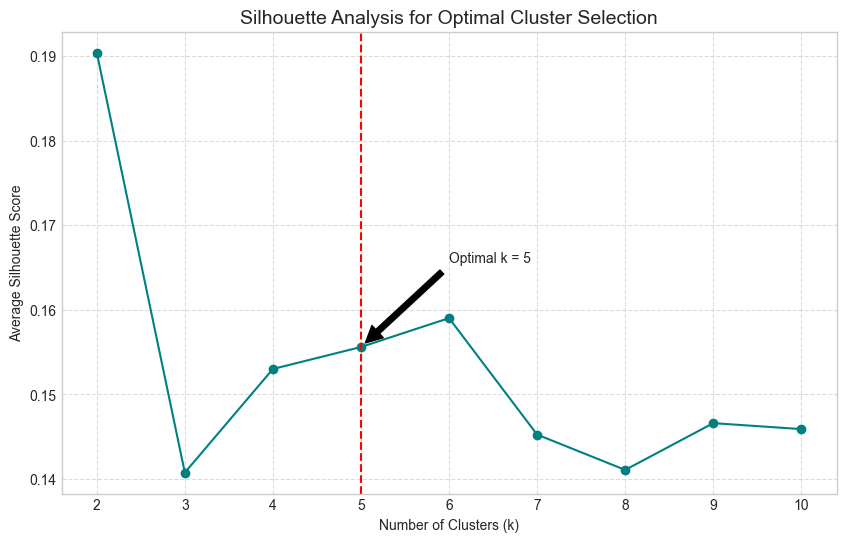

In [40]:
# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='-', color='teal')
plt.axvline(x=optimal_k, color='red', linestyle='--')
plt.title('Silhouette Analysis for Optimal Cluster Selection', fontsize=14)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.annotate(f'Optimal k = {optimal_k}',
             xy=(optimal_k, silhouette_scores[optimal_k-2]),  # -2 adjustment since silhouette starts at k=2
             xytext=(optimal_k+1, silhouette_scores[optimal_k-2]+0.01),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

## Cluster Visualization

The dimensionality reduction and radar charts provide visual insights into our five Spotify song clusters:

**PCA Visualization**: The 2D representation of our clusters shows the distribution of songs in feature space, with labeled centroids (red X's) indicating the focal points of each cluster. While there is some overlap between clusters, the centroids are well-positioned to represent distinct audio profiles. Principal Component 1 appears to separate songs based on energy-related characteristics, with Clusters 2 and 3 positioned further right (higher energy), while Principal Component 2 seems to differentiate based on rhythm and vocal characteristics, with Clusters 0 and 1 positioned higher on this axis.

**Radar Chart Patterns**: The radar charts reveal that tempo consistently stands out as a prominent feature across all clusters, creating a distinctive spike in each profile. Beyond this common pattern, each cluster shows subtle but important differences in how they balance other audio features.

**Cluster Profiles**:
- **Cluster 0** ("Moderate Energy Acoustic Tracks"): Shows balanced danceability (0.72) and moderate energy (0.67), with modest loudness (-6.88dB) and higher acousticness. These likely represent mainstream pop songs with acoustic elements.

- **Cluster 1** ("High Energy Dance Tracks"): Exhibits high danceability (0.74) and energy (0.73) with faster tempos (114.5 BPM) and moderate loudness. These appear to be upbeat, commercially-oriented tracks designed for dancing.

- **Cluster 2** ("Rhythmic Modern Tracks"): Demonstrates the highest danceability (0.85) with strong energy (0.78) but controlled loudness (-7.05dB), likely representing contemporary hip-hop and modern pop tracks.

- **Cluster 3** ("Fast-Paced Energetic Songs"): Features moderate danceability (0.54) but high energy (0.80) with the fastest tempo (132.4 BPM), representing EDM and high-intensity tracks.

- **Cluster 4** ("Quiet Atmospheric Tracks"): Shows moderate danceability (0.60) with notably lower energy (0.43) and significantly quieter loudness (-10.56dB), representing ambient, acoustic, or indie tracks.

The distinctive profiles of these clusters confirm that our clustering approach effectively captures meaningful patterns in the audio characteristics of Spotify songs. The PCA visualization with labeled centroids provides a clear map of how these different musical styles are positioned in the feature space, while the radar charts offer detailed insights into the specific audio characteristics that define each cluster.


### PCA Visualization

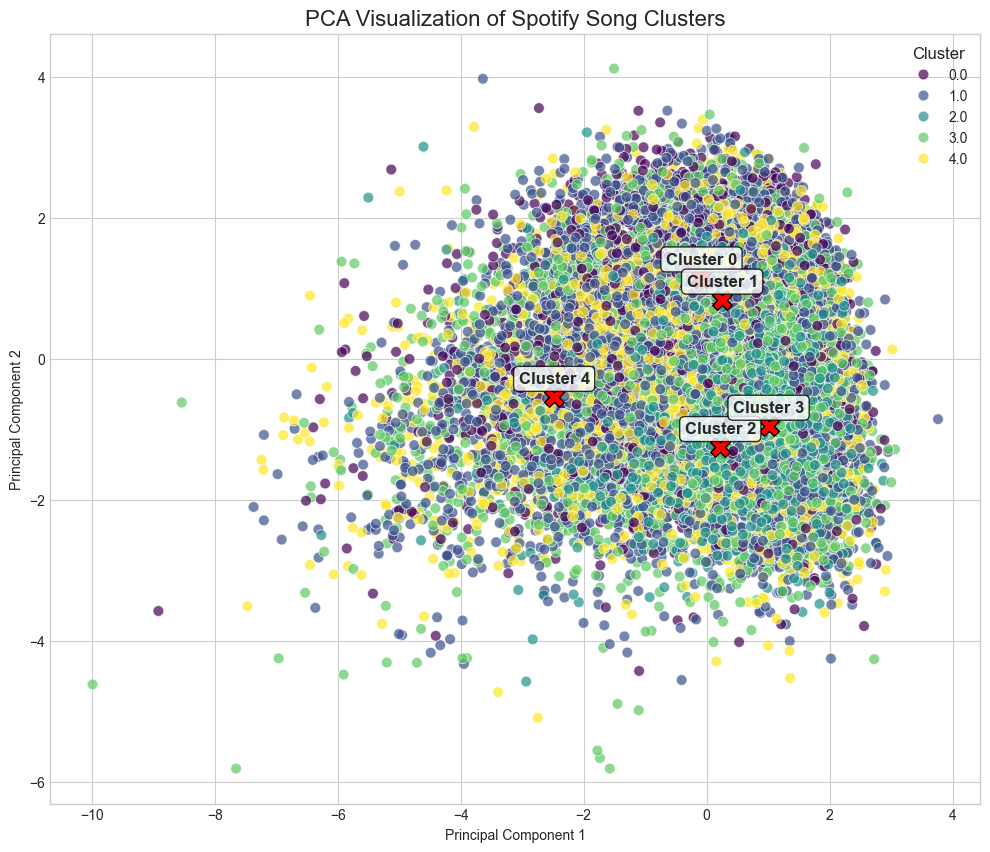

In [41]:
plt.figure(figsize=(12, 10))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis', s=60, alpha=0.7)
plt.title('PCA Visualization of Spotify Song Clusters', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add cluster centroids with labels
pca_centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(pca_centroids[:, 0], pca_centroids[:, 1], s=200, marker='X', c='red', edgecolor='black')

# Add labels to each centroid
for i, (x, y) in enumerate(pca_centroids):
    plt.annotate(f"Cluster {i}",
                 (x, y),
                 textcoords="offset points",
                 xytext=(0, 10),  # Offset text by 10 points above
                 ha='center',     # Horizontal alignment
                 fontsize=12,
                 fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

plt.legend(title='Cluster', title_fontsize=12)
plt.show()

### Cluster Profiles

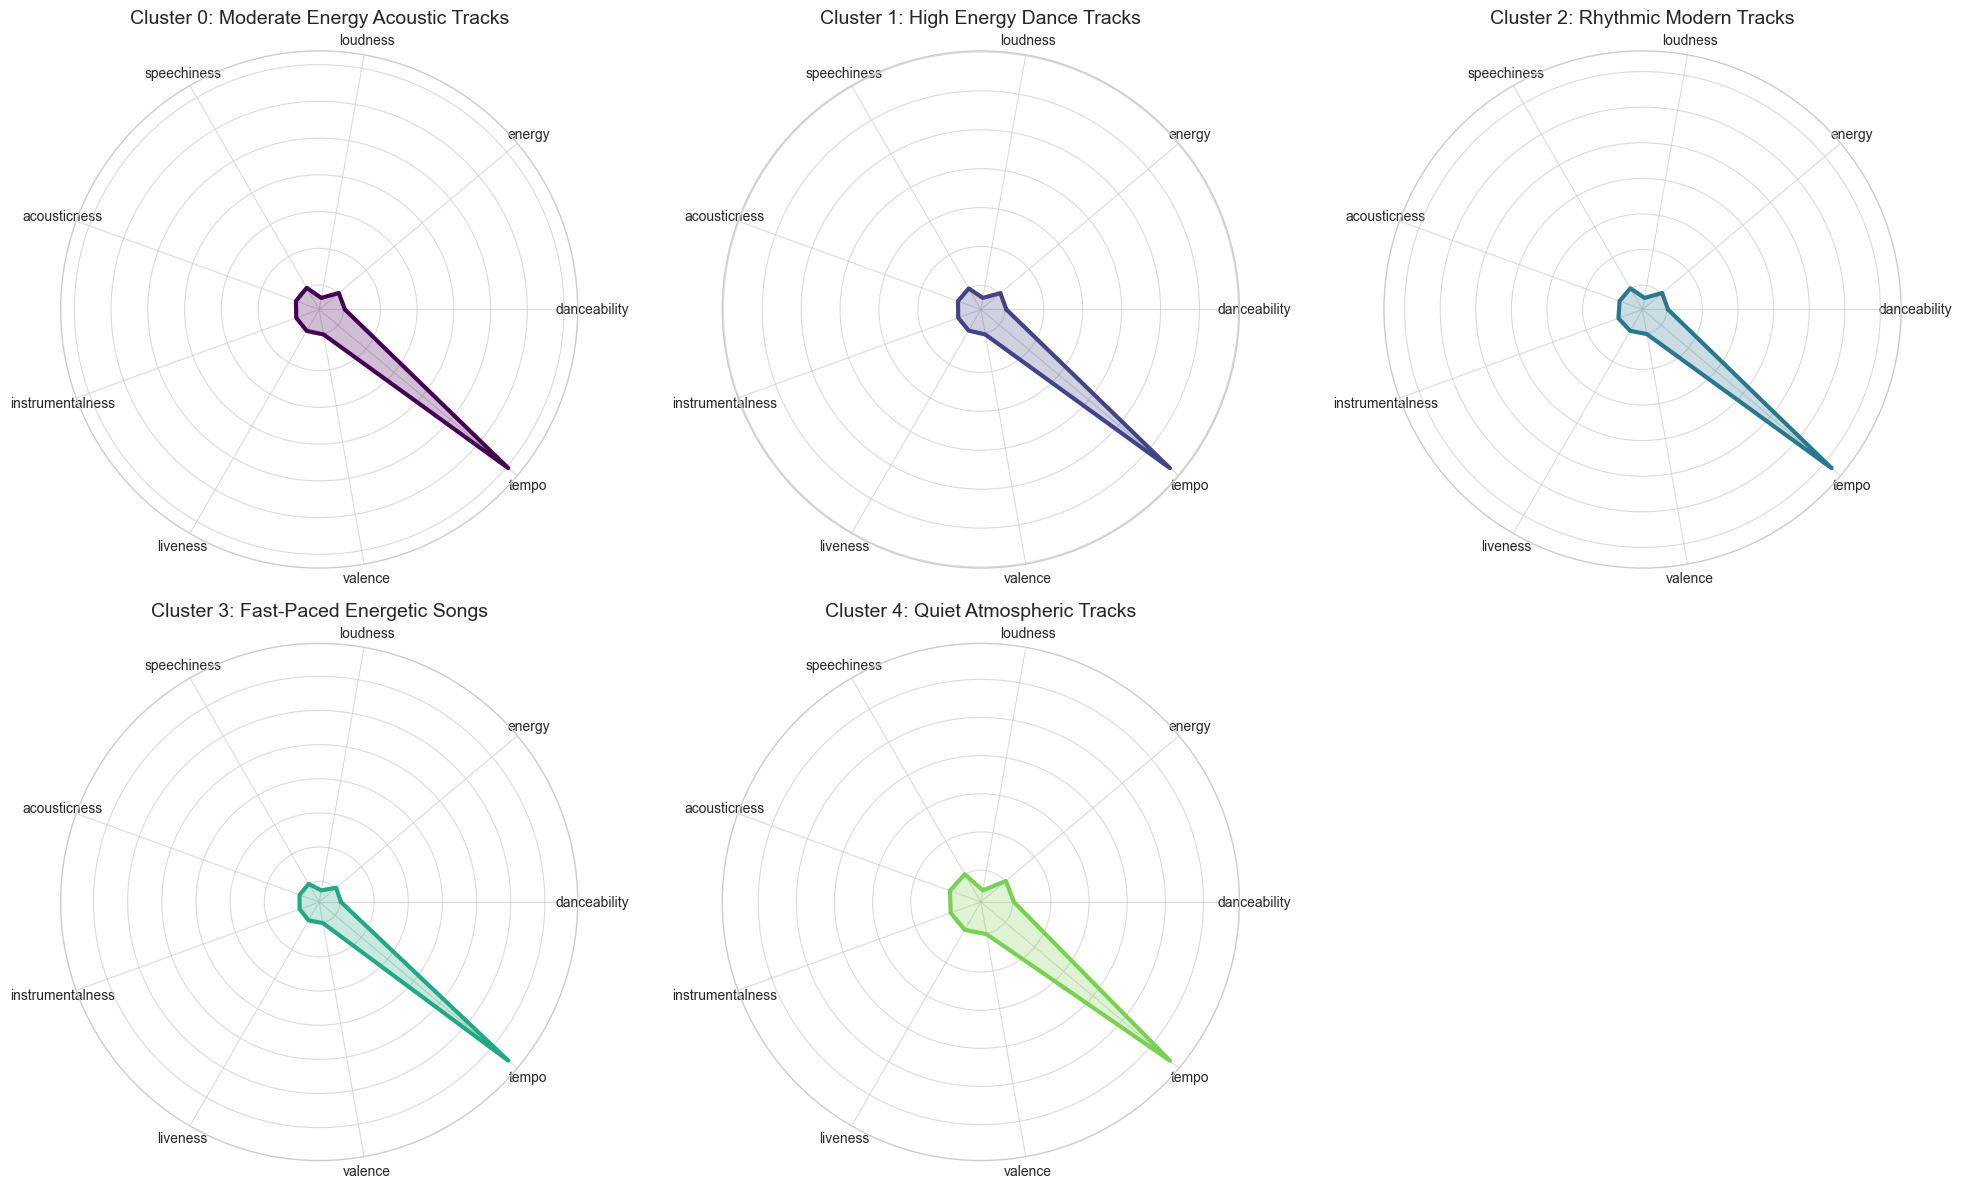

In [42]:
def improved_radar_chart(df, cluster_col, features):
    # Number of variables
    N = len(features)

    # Create angles for radar chart
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Close the loop

    # Create figure
    fig, ax = plt.subplots(figsize=(14, 10), subplot_kw=dict(polar=True))

    # Add variable labels at the correct positions
    plt.xticks(angles[:-1], features, size=14)

    # Remove redundant text in the center
    ax.set_yticklabels([])

    # Get color map
    colors = plt.cm.viridis(np.linspace(0, 1, len(df[cluster_col].unique())))

    # For each cluster
    for i, cluster in enumerate(sorted(df[cluster_col].unique())):
        # Get values for the cluster
        values = df[df[cluster_col] == cluster][features].mean().values.flatten().tolist()
        values += values[:1]  # Close the loop

        # Plot values
        ax.plot(angles, values, linewidth=3, label=f'Cluster {cluster}', color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])

    # Improve legend placement and formatting
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), fontsize=12)
    plt.title('Cluster Profiles Across Audio Features', size=18, pad=20)

    # Add grid
    ax.grid(True, linestyle='-', alpha=0.7)

    return fig, ax

# For individual radar charts with descriptive names
cluster_names = {
    0: "Moderate Energy Acoustic Tracks",
    1: "High Energy Dance Tracks",
    2: "Rhythmic Modern Tracks",
    3: "Fast-Paced Energetic Songs",
    4: "Quiet Atmospheric Tracks"
}

fig, axes = plt.subplots(2, 3, figsize=(20, 12), subplot_kw=dict(polar=True))
axes = axes.flatten()

# Get cluster means for all features
cluster_means = df_unique.groupby('cluster')[cluster_features].mean()

for i, cluster in enumerate(sorted(df_unique['cluster'].unique())):
    if i < 5:  # We have 5 clusters (0-4)
        # Get values for this cluster
        values = cluster_means.loc[cluster].values.tolist()
        values += values[:1]  # Close the loop

        # Create angles
        angles = [n / float(len(cluster_features)) * 2 * np.pi for n in range(len(cluster_features))]
        angles += angles[:1]

        # Plot on the appropriate subplot
        axes[i].plot(angles, values, linewidth=3, color=plt.cm.viridis(i/5))
        axes[i].fill(angles, values, alpha=0.25, color=plt.cm.viridis(i/5))
        axes[i].set_xticks(angles[:-1])
        axes[i].set_xticklabels(cluster_features, size=10)

        # Move title higher by adding vertical space
        axes[i].set_title(f'Cluster {cluster}: {cluster_names[cluster]}', size=14, pad=20)

        # Remove redundant y-labels
        axes[i].set_yticklabels([])

        axes[i].grid(True, linestyle='-', alpha=0.7)

# Remove the empty subplot if there is one
if len(axes) > 5:
    fig.delaxes(axes[5])

# Add more space between subplots to prevent overlap
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.tight_layout()
plt.show()

### Cluster-Popularity Relationship

The analysis of popularity across clusters reveals important patterns:

1. **Popularity Distribution**: The bar chart shows Clusters 1 and 4 have the highest proportions of high-popularity songs (approximately 41% and 40% respectively), slightly above the dataset average of 37%. Cluster 0 shows a moderate popularity rate (38%), while Cluster 3 is just below average (36%). Notably, Cluster 2 has a significantly lower proportion of popular songs (18%), well below the dataset average.

2. **Audio Characteristics and Popularity**: The clusters with higher popularity rates share some common characteristics:
   - Cluster 1 ("High Energy Dance Tracks"): High danceability (0.74) and energy (0.73) with conventional loudness
   - Cluster 4 ("Quiet Atmospheric Tracks"): Despite lower energy (0.43) and quieter loudness (-10.56dB), these tracks maintain high popularity, suggesting a dedicated audience for this style

3. **Genre-Cluster Relationship**: The stacked bar chart reveals distinct genre associations within each cluster:
   - **Cluster 0**: Dominated by rap (over 50%) with some r&b content
   - **Cluster 1**: More balanced with significant proportions of latin, pop, and rap genres
   - **Cluster 2**: Primarily EDM content (over 50%) with some rock
   - **Cluster 3**: Features significant rock content (over 25%) with latin and EDM
   - **Cluster 4**: More diverse with pop, rap, and r&b content

4. **Statistical Validation**: The ANOVA results confirm significant differences in all audio features across clusters (p < 0.001), with instrumentalness (F=20264.45) and speechiness (F=14025.74) showing the strongest discriminatory power.

These findings suggest that song popularity on Spotify follows multiple paths rather than a single formula. While high-energy dance tracks (Cluster 1) achieve above-average popularity as might be expected, quieter atmospheric tracks (Cluster 4) can also achieve similar popularity rates. Interestingly, EDM-dominated tracks (Cluster 2) show significantly lower popularity despite their distinct audio profile. This indicates that popularity prediction should consider both audio characteristics and genre context, as different listener communities may have different preferences.


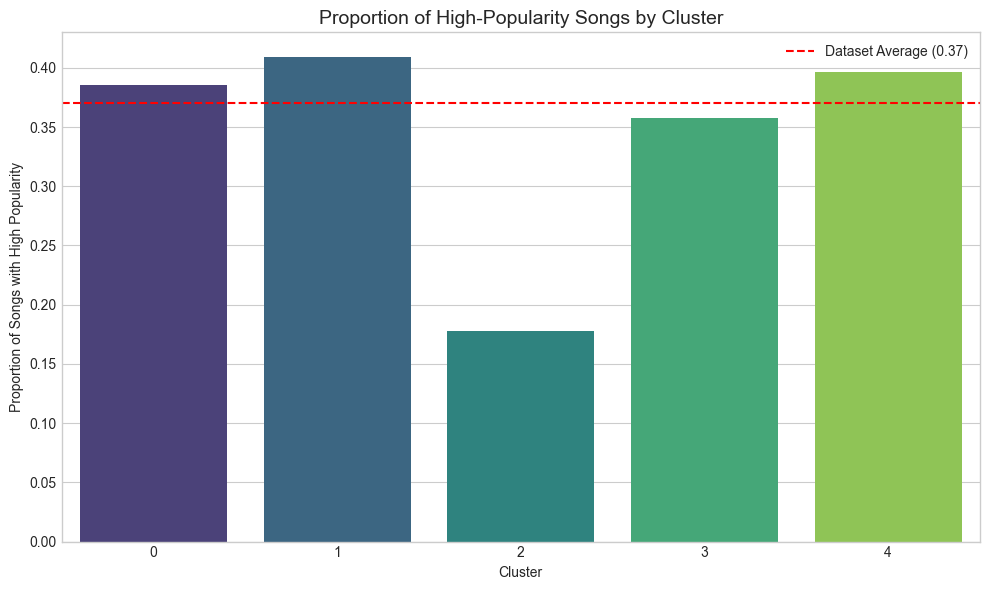

In [43]:
plt.figure(figsize=(10, 6))
pop_by_cluster = df_unique.groupby('cluster')['high_popularity'].mean().sort_values()
sns.barplot(x=pop_by_cluster.index, y=pop_by_cluster.values, palette='viridis')
plt.title('Proportion of High-Popularity Songs by Cluster', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('Proportion of Songs with High Popularity')
plt.axhline(y=df_unique['high_popularity'].mean(), color='red', linestyle='--',
            label=f'Dataset Average ({df_unique["high_popularity"].mean():.2f})')
plt.legend()
plt.tight_layout()
plt.show()

### Genre Distribution within Clusters

<Figure size 1400x800 with 0 Axes>

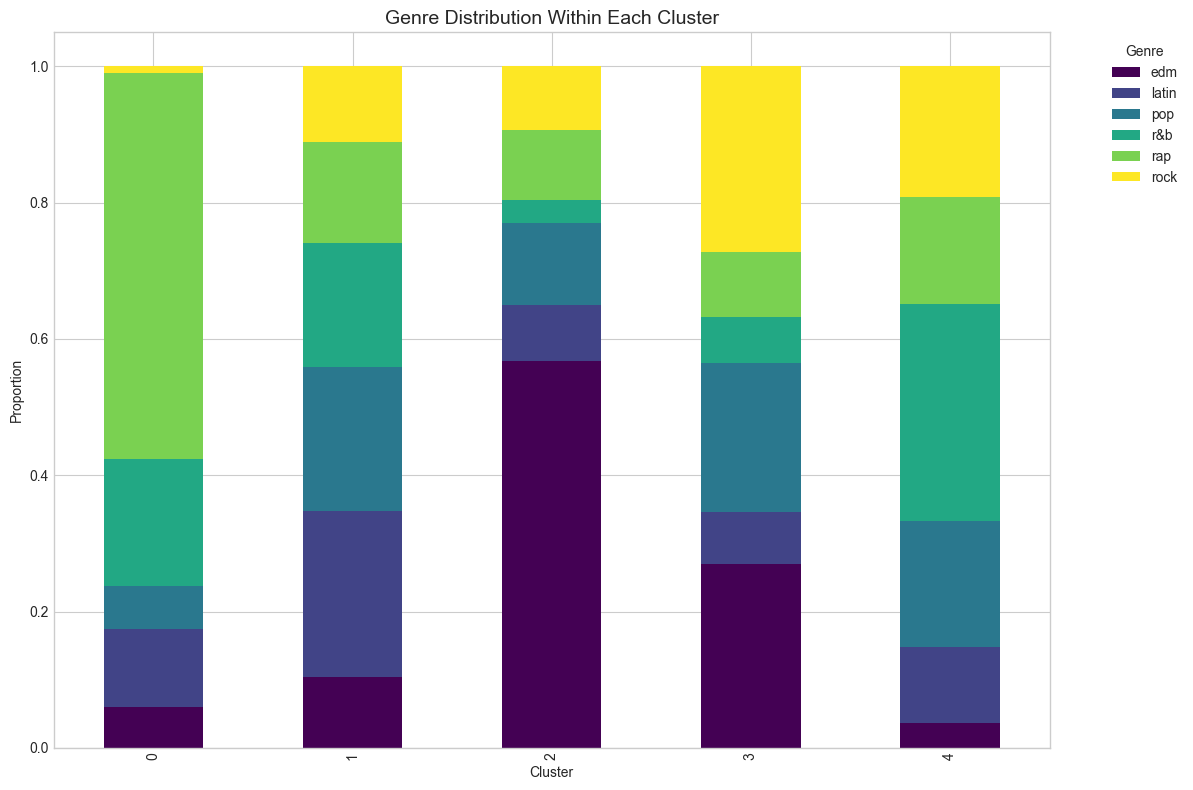

In [44]:
genre_cluster = pd.crosstab(df_unique['cluster'], df_unique['playlist_genre'])
genre_cluster_pct = genre_cluster.div(genre_cluster.sum(axis=1), axis=0)

plt.figure(figsize=(14, 8))
genre_cluster_pct.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Genre Distribution Within Each Cluster', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Model Fitting and Interpretation

We fit eight logistic regression models to predict song popularity on Spotify, defined as a binary outcome where high_popularity = 1 if track_popularity > 50, else 0. Prior to modeling, we applied log transformations to highly skewed features (instrumentalness and acousticness) and standardized all continuous predictors.


## Model Formulations and Performance

### Model 1: Intercept-Only (Baseline)
- **Coefficients**: 1 (intercept only)
- **Significant Coefficients**: 1 
- **Performance**: Accuracy = 0.6295, ROC AUC = 0.5000
- **Interpretation**: This model predicts all songs as low popularity, resulting in 0% sensitivity but 100% specificity. With an AUC of 0.5, it performs no better than random chance.

### Model 2: Categorical Inputs
- **Coefficients**: 18
- **Significant Coefficients**: 7
- **Top Significant Features**: playlist_genre[T.pop] (1.52), playlist_genre[T.rock] (1.20)
- **Performance**: Accuracy = 0.6302, ROC AUC = 0.6193
- **Interpretation**: Genre is a significant predictor of popularity, with pop and rock genres showing strong positive associations with popularity compared to the reference category.

### Model 3: Continuous Inputs
- **Coefficients**: 10
- **Significant Coefficients**: 9
- **Top Significant Features**: std_energy (-0.33), std_loudness (0.32)
- **Performance**: Accuracy = 0.6332, ROC AUC = 0.6222
- **Interpretation**: Energy shows a significant negative relationship with popularity, while loudness shows a positive relationship. This apparent contradiction (since energy and loudness are positively correlated) suggests complex interactions between audio features.

### Model 4: All Inputs
- **Coefficients**: 27
- **Significant Coefficients**: 13
- **Top Significant Features**: playlist_genre[T.rock] (1.32), playlist_genre[T.pop] (1.30)
- **Performance**: Accuracy = 0.6465, ROC AUC = 0.6660
- **Interpretation**: Genre remains the strongest predictor even when accounting for audio features. The model shows improved discriminative ability with both categorical and continuous predictors.

### Model 5: Continuous Inputs with Interactions
- **Coefficients**: 46
- **Significant Coefficients**: 23
- **Top Significant Features**: std_loudness (0.34), std_energy (-0.33)
- **Performance**: Accuracy = 0.6418, ROC AUC = 0.6389
- **Interpretation**: Adding interactions between continuous features increased model complexity but didn't substantially improve performance over the simpler Model 4.

### Model 6: Categorical-Continuous Interactions
- **Coefficients**: 48
- **Significant Coefficients**: 25
- **Top Significant Features**: playlist_genre[T.pop] (1.24), playlist_genre[T.rock] (1.15)
- **Performance**: Accuracy = 0.6556, ROC AUC = 0.6745
- **Interpretation**: This model achieves the highest ROC AUC and accuracy, suggesting that the effect of audio features on popularity varies significantly by genre. This is confirmed by multiple significant interaction terms.

### Model 7: Polynomial Features
- **Coefficients**: 17
- **Significant Coefficients**: 14
- **Top Significant Features**: playlist_genre[T.pop] (1.30), playlist_genre[T.rock] (1.29)
- **Performance**: Accuracy = 0.6472, ROC AUC = 0.6654
- **Interpretation**: Adding polynomial terms for danceability and energy captured nonlinear relationships with popularity, though genre remains the strongest predictor.

### Model 8: Cluster-Based Model
- **Coefficients**: 13
- **Significant Coefficients**: 11
- **Top Significant Features**: playlist_genre[T.pop] (1.27), playlist_genre[T.rock] (1.07)
- **Performance**: Accuracy = 0.6401, ROC AUC = 0.6450
- **Interpretation**: Using cluster membership as a feature provided a more efficient model with fewer coefficients while maintaining reasonable performance.

## Analysis of the Best Model (Model 6)

The Category-Continuous Interactions model reveals important insights about the factors influencing song popularity:

1. **Genre Effects**: All genre categories (pop, rock, rap, latin, r&b) have significant positive coefficients, with pop (1.24) and rock (1.15) showing the strongest effects.

2. **Audio Feature Effects**: The baseline effects of audio features vary:
   - Energy: Negative effect (-0.16)
   - Loudness: Positive effect (0.29)
   - Instrumentalness: Negative effect (-0.22)
   - Acousticness: Positive effect (0.23)

3. **Interaction Effects**: The significant interactions reveal that audio features' impact on popularity varies substantially by genre:
   - Danceability is particularly important for popularity in rap (0.33) and pop (0.19) genres
   - Energy has a negative relationship with popularity across genres, especially for r&b (-0.34)
   - Loudness has a positive effect across most genres
   - Instrumentalness has a negative baseline effect, but shows positive interactions with rap (0.23) and rock (0.11)
   - Acousticness has varying effects: positive baseline but negative for rock (-0.30) and r&b (-0.18)

## Overall Findings

1. **Best Model Performance**: Model 6 (Categorical-Continuous Interactions) achieved the highest ROC AUC (0.6745) and accuracy (0.6556), significantly outperforming the baseline model and all simpler formulations.

2. **Model Complexity vs. Performance**: The plot shows that while more complex models generally performed better, the relationship isn't strictly linear. The 48-coefficient Model 6 outperformed the 46-coefficient Model 5, indicating that the nature of the interactions matters more than just the number of coefficients.

3. **Most Important Predictors**:
   - **Genre**: Consistently the strongest predictor across all models, with pop and rock genres showing the highest positive associations with popularity.
   - **Audio Features**: Effects vary significantly by genre, highlighting the importance of context in predicting popularity.

4. **Feature Interactions**: The significant interactions in Model 6 confirm our clustering analysis finding that different genres have distinct audio profiles associated with popularity.

5. **Predictive Limitations**: Even our best model achieved modest performance (AUC = 0.6745), indicating that predicting song popularity is challenging and likely influenced by factors beyond audio features and genre, such as artist reputation, marketing, and cultural trends.

These findings align with our exploratory analysis, confirming that song popularity on Spotify is influenced by a complex interplay of genre context and audio characteristics, with different features mattering differently across genres.

## Data Preparation for Modeling

In [45]:
# First, let's prepare our data for modeling
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score

# Create a copy of the dataframe for modeling
model_df = df_unique.copy()

# 1. Check for non-Gaussian distributions that might need transformation
# Based on our EDA, instrumentalness and acousticness have highly skewed distributions
# Apply log transformation (adding a small constant to avoid log(0))
model_df['log_instrumentalness'] = np.log(model_df['instrumentalness'] + 0.001)
model_df['log_acousticness'] = np.log(model_df['acousticness'] + 0.001)

# 2. Standardize continuous features since they have different scales
features_to_standardize = ['danceability', 'energy', 'loudness', 'speechiness',
                           'liveness', 'valence', 'tempo', 'log_instrumentalness',
                           'log_acousticness']

scaler = StandardScaler()
model_df[['std_' + col for col in features_to_standardize]] = scaler.fit_transform(model_df[features_to_standardize])

# 3. Prepare categorical variables
# Convert playlist_genre to category type
model_df['playlist_genre'] = model_df['playlist_genre'].astype('category')
model_df['key'] = model_df['key'].astype('category')
model_df['mode'] = model_df['mode'].astype('category')

# Function to fit logistic regression models and evaluate them
def fit_and_evaluate_model(formula, data):
    # Fit the model
    model = smf.logit(formula=formula, data=data).fit(disp=False)

    # Get predictions
    predictions = model.predict(data)
    binary_predictions = (predictions > 0.5).astype(int)

    # Confusion matrix
    cm = confusion_matrix(data['high_popularity'], binary_predictions)

    # Calculate metrics
    accuracy = accuracy_score(data['high_popularity'], binary_predictions)
    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    fpr = 1 - specificity

    # ROC curve
    fpr_curve, tpr_curve, _ = roc_curve(data['high_popularity'], predictions)
    roc_auc = auc(fpr_curve, tpr_curve)

    # Coefficient analysis
    coef_summary = model.summary2().tables[1]
    sig_coefs = coef_summary[coef_summary['P>|z|'] < 0.05]
    n_coefs = len(model.params)
    n_sig_coefs = len(sig_coefs)

    # Get top magnitude coefficients (excluding intercept)
    if n_sig_coefs > 1:
        sig_coefs_no_intercept = sig_coefs[~sig_coefs.index.str.contains('Intercept')]
        sig_coefs_no_intercept['abs_coef'] = sig_coefs_no_intercept['Coef.'].abs()
        top_coefs = sig_coefs_no_intercept.sort_values('abs_coef', ascending=False).head(2)
    else:
        top_coefs = None

    return {
        'model': model,
        'confusion_matrix': cm,
        'accuracy': accuracy,
        'sensitivity': sensitivity,
        'specificity': specificity,
        'fpr': fpr,
        'roc_auc': roc_auc,
        'fpr_curve': fpr_curve,
        'tpr_curve': tpr_curve,
        'n_coefs': n_coefs,
        'n_sig_coefs': n_sig_coefs,
        'sig_coefs': sig_coefs,
        'top_coefs': top_coefs
    }

# Plot confusion matrix
def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc, title="ROC Curve"):
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

## Model 1: Intercept-Only (Constant Average)

Model 1: Intercept-Only Model
Number of coefficients estimated: 1
Number of statistically significant coefficients: 1
Significant coefficients:
              Coef.  Std.Err.          z  P>|z|    [0.025    0.975]
Intercept -0.530057  0.012297 -43.106016    0.0 -0.554158 -0.505956

Model Performance:
Accuracy: 0.6295
Sensitivity: 0.0000
Specificity: 1.0000
False Positive Rate: 0.0000
ROC AUC: 0.5000


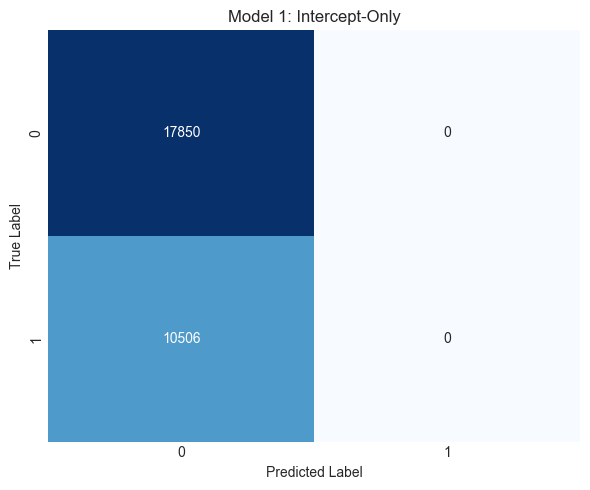

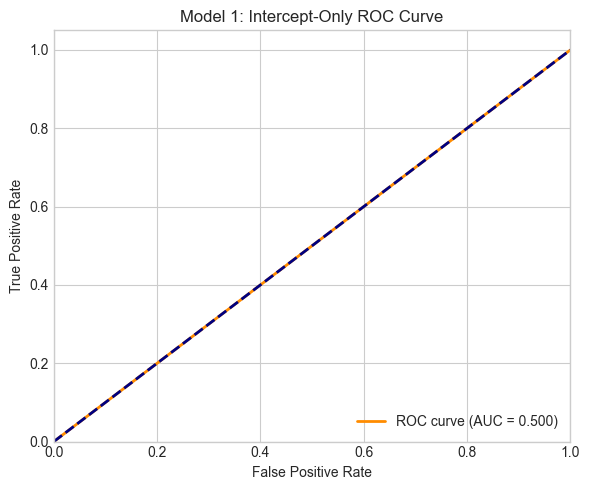

In [46]:
# Model 1: Intercept-Only (Constant Average)
formula_1 = "high_popularity ~ 1"
results_1 = fit_and_evaluate_model(formula_1, model_df)

print("Model 1: Intercept-Only Model")
print(f"Number of coefficients estimated: {results_1['n_coefs']}")
print(f"Number of statistically significant coefficients: {results_1['n_sig_coefs']}")
print("Significant coefficients:")
print(results_1['sig_coefs'])
print("\nModel Performance:")
print(f"Accuracy: {results_1['accuracy']:.4f}")
print(f"Sensitivity: {results_1['sensitivity']:.4f}")
print(f"Specificity: {results_1['specificity']:.4f}")
print(f"False Positive Rate: {results_1['fpr']:.4f}")
print(f"ROC AUC: {results_1['roc_auc']:.4f}")

plot_confusion_matrix(results_1['confusion_matrix'], "Model 1: Intercept-Only")
plot_roc_curve(results_1['fpr_curve'], results_1['tpr_curve'], results_1['roc_auc'],
               "Model 1: Intercept-Only ROC Curve")

## Model 2: Categorical Inputs with Additive Features

Model 2: Categorical Inputs with Additive Features
Number of coefficients estimated: 18
Number of statistically significant coefficients: 7
Top significant coefficients by magnitude:
                              Coef.  Std.Err.          z          P>|z|  \
C(playlist_genre)[T.pop]   1.520747  0.046949  32.391765  3.584805e-230   
C(playlist_genre)[T.rock]  1.198323  0.049213  24.349751  5.832573e-131   

                             [0.025    0.975]  abs_coef  
C(playlist_genre)[T.pop]   1.428730  1.612765  1.520747  
C(playlist_genre)[T.rock]  1.101868  1.294779  1.198323  

Model Performance:
Accuracy: 0.6302
Sensitivity: 0.0943
Specificity: 0.9457
False Positive Rate: 0.0543
ROC AUC: 0.6193


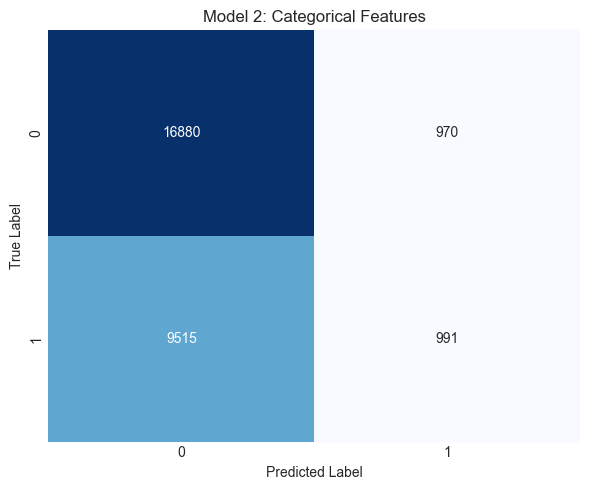

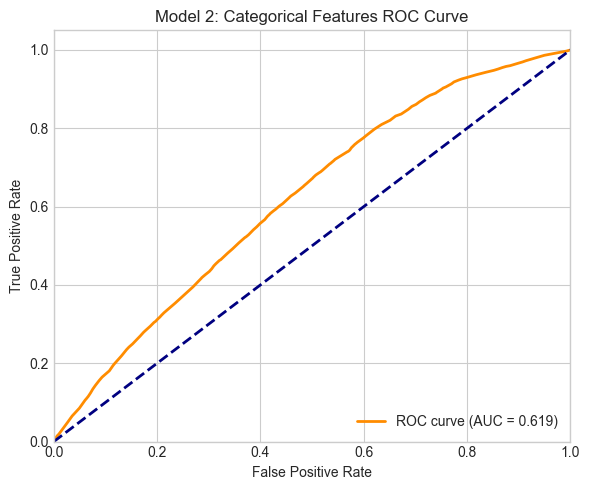

In [47]:
# Model 2: Categorical Inputs with Additive Features
formula_2 = "high_popularity ~ C(playlist_genre) + C(key) + C(mode)"
results_2 = fit_and_evaluate_model(formula_2, model_df)

print("Model 2: Categorical Inputs with Additive Features")
print(f"Number of coefficients estimated: {results_2['n_coefs']}")
print(f"Number of statistically significant coefficients: {results_2['n_sig_coefs']}")
print("Top significant coefficients by magnitude:")
print(results_2['top_coefs'])
print("\nModel Performance:")
print(f"Accuracy: {results_2['accuracy']:.4f}")
print(f"Sensitivity: {results_2['sensitivity']:.4f}")
print(f"Specificity: {results_2['specificity']:.4f}")
print(f"False Positive Rate: {results_2['fpr']:.4f}")
print(f"ROC AUC: {results_2['roc_auc']:.4f}")

plot_confusion_matrix(results_2['confusion_matrix'], "Model 2: Categorical Features")
plot_roc_curve(results_2['fpr_curve'], results_2['tpr_curve'], results_2['roc_auc'],
               "Model 2: Categorical Features ROC Curve")

## Model 3: Continuous Inputs with Linear Additive Features

Model 3: Continuous Inputs with Linear Additive Features
Number of coefficients estimated: 10
Number of statistically significant coefficients: 9
Top significant coefficients by magnitude:
                 Coef.  Std.Err.          z         P>|z|    [0.025    0.975]  \
std_energy   -0.334813  0.020866 -16.045636  6.132754e-58 -0.375710 -0.293916   
std_loudness  0.315587  0.019351  16.308372  8.605629e-60  0.277659  0.353515   

              abs_coef  
std_energy    0.334813  
std_loudness  0.315587  

Model Performance:
Accuracy: 0.6332
Sensitivity: 0.1080
Specificity: 0.9423
False Positive Rate: 0.0577
ROC AUC: 0.6222


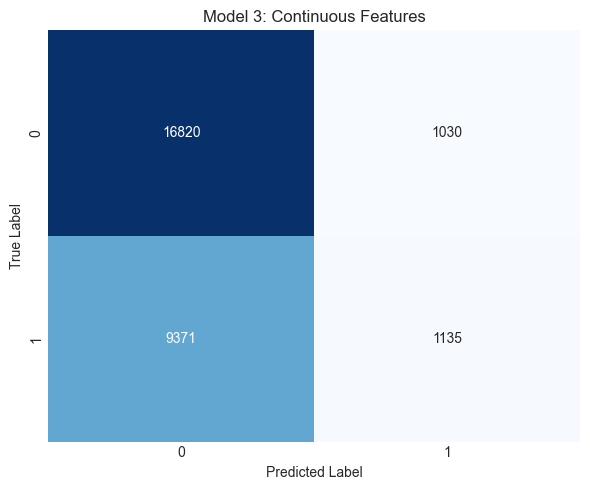

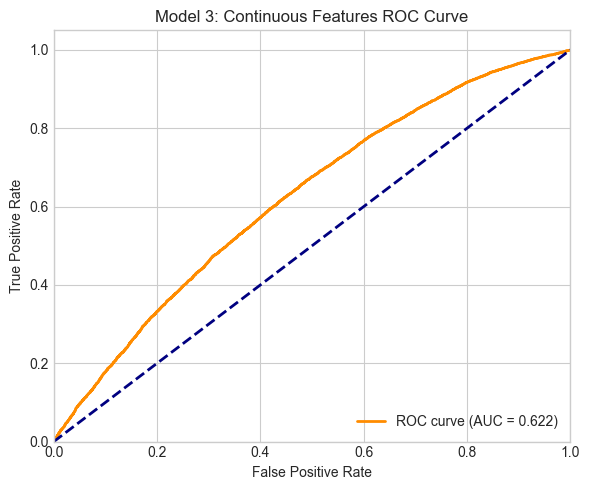

In [48]:
# Model 3: Continuous Inputs with Linear Additive Features
formula_3 = "high_popularity ~ std_danceability + std_energy + std_loudness + std_speechiness + \
             std_log_instrumentalness + std_log_acousticness + std_liveness + std_valence + std_tempo"
results_3 = fit_and_evaluate_model(formula_3, model_df)

print("Model 3: Continuous Inputs with Linear Additive Features")
print(f"Number of coefficients estimated: {results_3['n_coefs']}")
print(f"Number of statistically significant coefficients: {results_3['n_sig_coefs']}")
print("Top significant coefficients by magnitude:")
print(results_3['top_coefs'])
print("\nModel Performance:")
print(f"Accuracy: {results_3['accuracy']:.4f}")
print(f"Sensitivity: {results_3['sensitivity']:.4f}")
print(f"Specificity: {results_3['specificity']:.4f}")
print(f"False Positive Rate: {results_3['fpr']:.4f}")
print(f"ROC AUC: {results_3['roc_auc']:.4f}")

plot_confusion_matrix(results_3['confusion_matrix'], "Model 3: Continuous Features")
plot_roc_curve(results_3['fpr_curve'], results_3['tpr_curve'], results_3['roc_auc'],
               "Model 3: Continuous Features ROC Curve")

## Model 4: All Inputs with Linear Additive Features

Model 4: All Inputs with Linear Additive Features
Number of coefficients estimated: 27
Number of statistically significant coefficients: 13
Top significant coefficients by magnitude:
                              Coef.  Std.Err.          z          P>|z|  \
C(playlist_genre)[T.rock]  1.320891  0.055647  23.737152  1.491465e-124   
C(playlist_genre)[T.pop]   1.301434  0.049929  26.065692  8.932768e-150   

                             [0.025    0.975]  abs_coef  
C(playlist_genre)[T.rock]  1.211826  1.429956  1.320891  
C(playlist_genre)[T.pop]   1.203575  1.399293  1.301434  

Model Performance:
Accuracy: 0.6465
Sensitivity: 0.2553
Specificity: 0.8768
False Positive Rate: 0.1232
ROC AUC: 0.6660


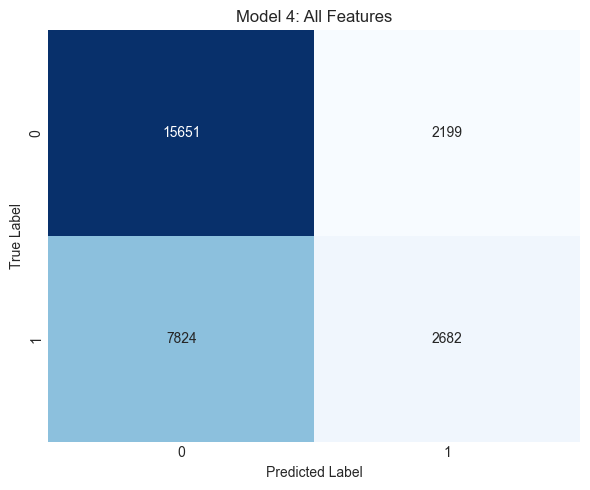

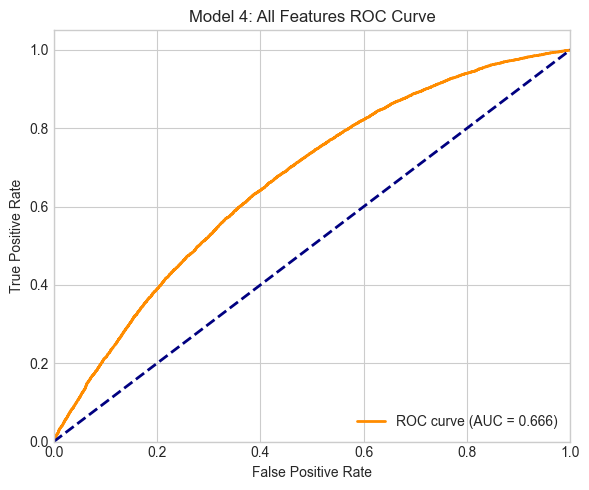

In [49]:
# Model 4: All Inputs with Linear Additive Features
formula_4 = "high_popularity ~ C(playlist_genre) + C(key) + C(mode) + \
             std_danceability + std_energy + std_loudness + std_speechiness + \
             std_log_instrumentalness + std_log_acousticness + std_liveness + std_valence + std_tempo"
results_4 = fit_and_evaluate_model(formula_4, model_df)

print("Model 4: All Inputs with Linear Additive Features")
print(f"Number of coefficients estimated: {results_4['n_coefs']}")
print(f"Number of statistically significant coefficients: {results_4['n_sig_coefs']}")
print("Top significant coefficients by magnitude:")
print(results_4['top_coefs'])
print("\nModel Performance:")
print(f"Accuracy: {results_4['accuracy']:.4f}")
print(f"Sensitivity: {results_4['sensitivity']:.4f}")
print(f"Specificity: {results_4['specificity']:.4f}")
print(f"False Positive Rate: {results_4['fpr']:.4f}")
print(f"ROC AUC: {results_4['roc_auc']:.4f}")

plot_confusion_matrix(results_4['confusion_matrix'], "Model 4: All Features")
plot_roc_curve(results_4['fpr_curve'], results_4['tpr_curve'], results_4['roc_auc'],
               "Model 4: All Features ROC Curve")

## Model 5: Continuous Inputs with Main Effects and Pair-wise Interactions

Model 5: Continuous Inputs with Main Effects and Pair-wise Interactions
Number of coefficients estimated: 46
Number of statistically significant coefficients: 23
Top significant coefficients by magnitude:
                 Coef.  Std.Err.          z         P>|z|    [0.025    0.975]  \
std_loudness  0.340979  0.021083  16.173156  7.799850e-59  0.299657  0.382301   
std_energy   -0.326859  0.022318 -14.645816  1.432703e-48 -0.370601 -0.283118   

              abs_coef  
std_loudness  0.340979  
std_energy    0.326859  

Model Performance:
Accuracy: 0.6418
Sensitivity: 0.1623
Specificity: 0.9240
False Positive Rate: 0.0760
ROC AUC: 0.6389


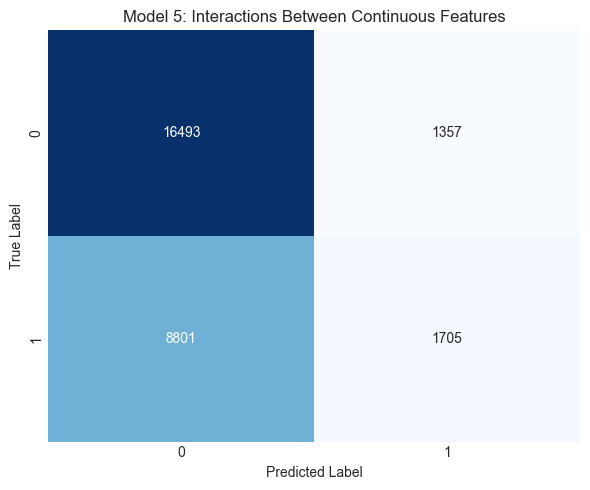

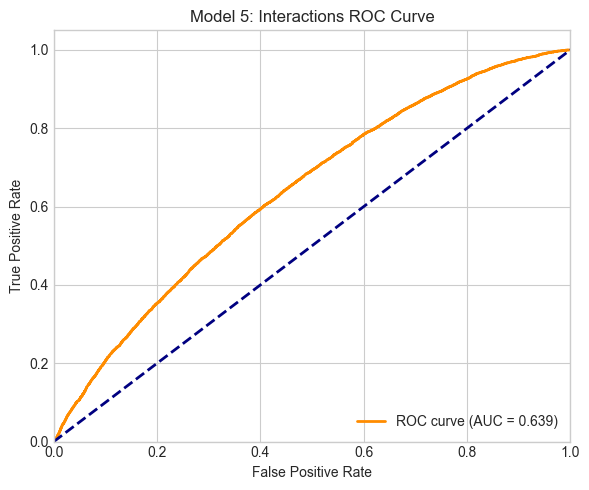

In [50]:
# Model 5: Continuous Inputs with Main Effects and Pair-wise Interactions
formula_5 = "high_popularity ~ (std_danceability + std_energy + std_loudness + std_speechiness + \
             std_log_instrumentalness + std_log_acousticness + std_liveness + std_valence + std_tempo)**2"
results_5 = fit_and_evaluate_model(formula_5, model_df)

print("Model 5: Continuous Inputs with Main Effects and Pair-wise Interactions")
print(f"Number of coefficients estimated: {results_5['n_coefs']}")
print(f"Number of statistically significant coefficients: {results_5['n_sig_coefs']}")
print("Top significant coefficients by magnitude:")
print(results_5['top_coefs'])
print("\nModel Performance:")
print(f"Accuracy: {results_5['accuracy']:.4f}")
print(f"Sensitivity: {results_5['sensitivity']:.4f}")
print(f"Specificity: {results_5['specificity']:.4f}")
print(f"False Positive Rate: {results_5['fpr']:.4f}")
print(f"ROC AUC: {results_5['roc_auc']:.4f}")

plot_confusion_matrix(results_5['confusion_matrix'], "Model 5: Interactions Between Continuous Features")
plot_roc_curve(results_5['fpr_curve'], results_5['tpr_curve'], results_5['roc_auc'],
               "Model 5: Interactions ROC Curve")

## Model 6: Interact Categorical Inputs with Continuous Inputs

Model 6: Interacting Categorical and Continuous Inputs
Number of coefficients estimated: 48
Number of statistically significant coefficients: 25
Top significant coefficients by magnitude:
                              Coef.  Std.Err.          z         P>|z|  \
C(playlist_genre)[T.pop]   1.239452  0.059516  20.825466  2.544399e-96   
C(playlist_genre)[T.rock]  1.146219  0.069652  16.456347  7.552279e-61   

                             [0.025    0.975]  abs_coef  
C(playlist_genre)[T.pop]   1.122802  1.356101  1.239452  
C(playlist_genre)[T.rock]  1.009704  1.282735  1.146219  

Model Performance:
Accuracy: 0.6556
Sensitivity: 0.2768
Specificity: 0.8785
False Positive Rate: 0.1215
ROC AUC: 0.6745


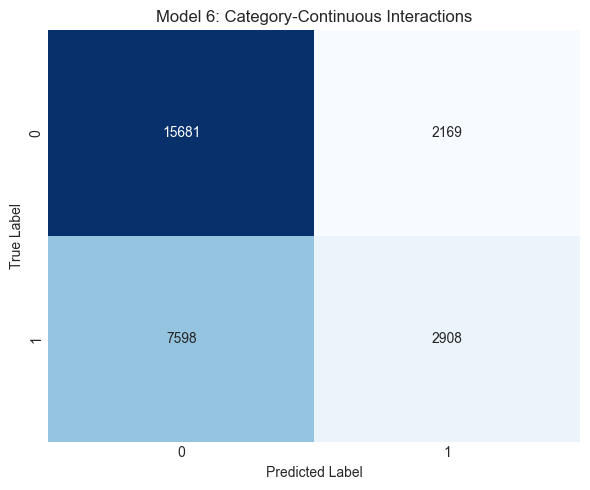

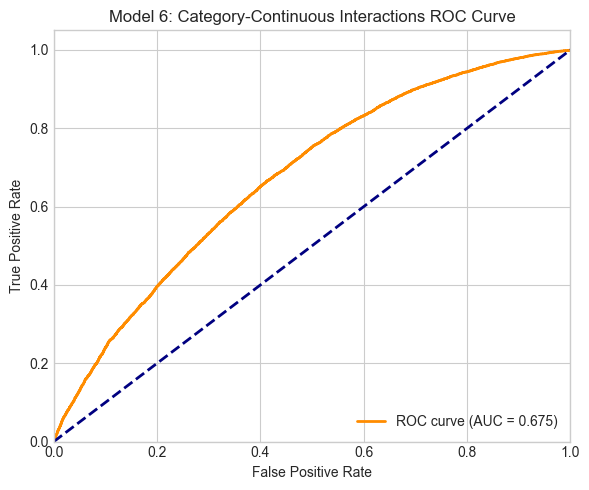

In [51]:
# Model 6: Interact Categorical Inputs with Continuous Inputs
formula_6 = "high_popularity ~ C(playlist_genre) * (std_danceability + std_energy + std_loudness + \
             std_log_instrumentalness + std_log_acousticness) + C(mode) + C(key)"
results_6 = fit_and_evaluate_model(formula_6, model_df)

print("Model 6: Interacting Categorical and Continuous Inputs")
print(f"Number of coefficients estimated: {results_6['n_coefs']}")
print(f"Number of statistically significant coefficients: {results_6['n_sig_coefs']}")
print("Top significant coefficients by magnitude:")
print(results_6['top_coefs'])
print("\nModel Performance:")
print(f"Accuracy: {results_6['accuracy']:.4f}")
print(f"Sensitivity: {results_6['sensitivity']:.4f}")
print(f"Specificity: {results_6['specificity']:.4f}")
print(f"False Positive Rate: {results_6['fpr']:.4f}")
print(f"ROC AUC: {results_6['roc_auc']:.4f}")

plot_confusion_matrix(results_6['confusion_matrix'], "Model 6: Category-Continuous Interactions")
plot_roc_curve(results_6['fpr_curve'], results_6['tpr_curve'], results_6['roc_auc'],
               "Model 6: Category-Continuous Interactions ROC Curve")

## Model 7: Polynomial Features for Non-Linear Relationships

Model 7: Polynomial Features for Non-Linear Relationships
Number of coefficients estimated: 17
Number of statistically significant coefficients: 14
Top significant coefficients by magnitude:
                              Coef.  Std.Err.          z          P>|z|  \
C(playlist_genre)[T.pop]   1.302341  0.049945  26.075479  6.918592e-150   
C(playlist_genre)[T.rock]  1.291062  0.055655  23.197452  4.830964e-119   

                            [0.025    0.975]  abs_coef  
C(playlist_genre)[T.pop]   1.20445  1.400231  1.302341  
C(playlist_genre)[T.rock]  1.18198  1.400145  1.291062  

Model Performance:
Accuracy: 0.6472
Sensitivity: 0.2564
Specificity: 0.8771
False Positive Rate: 0.1229
ROC AUC: 0.6654


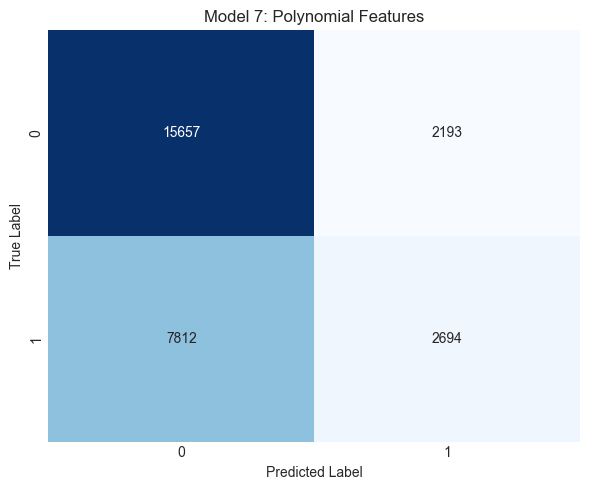

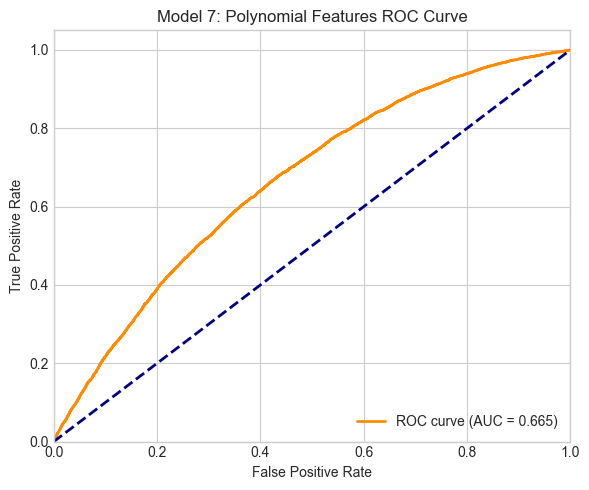

In [52]:
# Based on EDA, adding polynomial terms for danceability and energy
model_df['std_danceability_squared'] = model_df['std_danceability']**2
model_df['std_energy_squared'] = model_df['std_energy']**2

# Model 7: Polynomial Features for Non-Linear Relationships
formula_7 = "high_popularity ~ std_danceability + std_energy + std_loudness + std_speechiness + \
             std_log_instrumentalness + std_log_acousticness + std_liveness + std_valence + std_tempo + \
             std_danceability_squared + std_energy_squared + C(playlist_genre)"
results_7 = fit_and_evaluate_model(formula_7, model_df)

print("Model 7: Polynomial Features for Non-Linear Relationships")
print(f"Number of coefficients estimated: {results_7['n_coefs']}")
print(f"Number of statistically significant coefficients: {results_7['n_sig_coefs']}")
print("Top significant coefficients by magnitude:")
print(results_7['top_coefs'])
print("\nModel Performance:")
print(f"Accuracy: {results_7['accuracy']:.4f}")
print(f"Sensitivity: {results_7['sensitivity']:.4f}")
print(f"Specificity: {results_7['specificity']:.4f}")
print(f"False Positive Rate: {results_7['fpr']:.4f}")
print(f"ROC AUC: {results_7['roc_auc']:.4f}")

plot_confusion_matrix(results_7['confusion_matrix'], "Model 7: Polynomial Features")
plot_roc_curve(results_7['fpr_curve'], results_7['tpr_curve'], results_7['roc_auc'],
               "Model 7: Polynomial Features ROC Curve")

## Model 8: Cluster-Based Model

Model 8: Cluster-Based Model
Number of coefficients estimated: 13
Number of statistically significant coefficients: 11
Top significant coefficients by magnitude:
                              Coef.  Std.Err.          z          P>|z|  \
C(playlist_genre)[T.pop]   1.272128  0.049254  25.827928  4.307418e-147   
C(playlist_genre)[T.rock]  1.074047  0.052554  20.437174   7.813396e-93   

                             [0.025    0.975]  abs_coef  
C(playlist_genre)[T.pop]   1.175592  1.368664  1.272128  
C(playlist_genre)[T.rock]  0.971044  1.177050  1.074047  

Model Performance:
Accuracy: 0.6401
Sensitivity: 0.1861
Specificity: 0.9074
False Positive Rate: 0.0926
ROC AUC: 0.6450


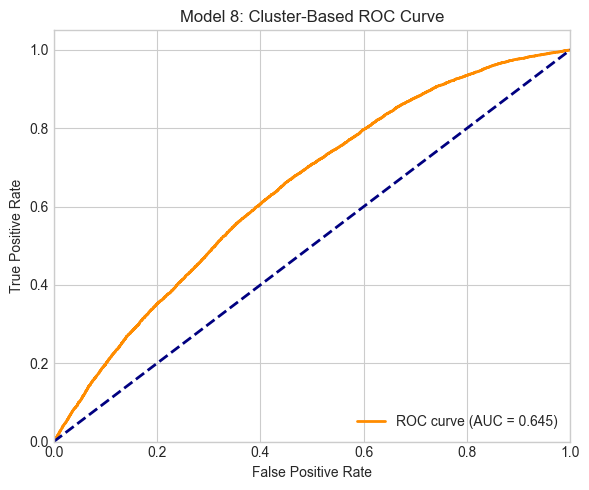

In [53]:
# Based on our cluster analysis, we can use cluster membership as a feature
# Model 8: Cluster-Based Model
formula_8 = "high_popularity ~ C(cluster) + std_danceability + std_energy + \
             std_log_instrumentalness + C(playlist_genre)"
results_8 = fit_and_evaluate_model(formula_8, model_df)

print("Model 8: Cluster-Based Model")
print(f"Number of coefficients estimated: {results_8['n_coefs']}")
print(f"Number of statistically significant coefficients: {results_8['n_sig_coefs']}")
print("Top significant coefficients by magnitude:")
print(results_8['top_coefs'])
print("\nModel Performance:")
print(f"Accuracy: {results_8['accuracy']:.4f}")
print(f"Sensitivity: {results_8['sensitivity']:.4f}")
print(f"Specificity: {results_8['specificity']:.4f}")
print(f"False Positive Rate: {results_8['fpr']:.4f}")
print(f"ROC AUC: {results_8['roc_auc']:.4f}")

plot_confusion_matrix(results_8['confusion_matrix'], "Model 8: Cluster-Based")
plot_roc_curve(results_8['fpr_curve'], results_8['tpr_curve'], results_8['roc_auc'],
               "Model 8: Cluster-Based ROC Curve")

## Model Comparison

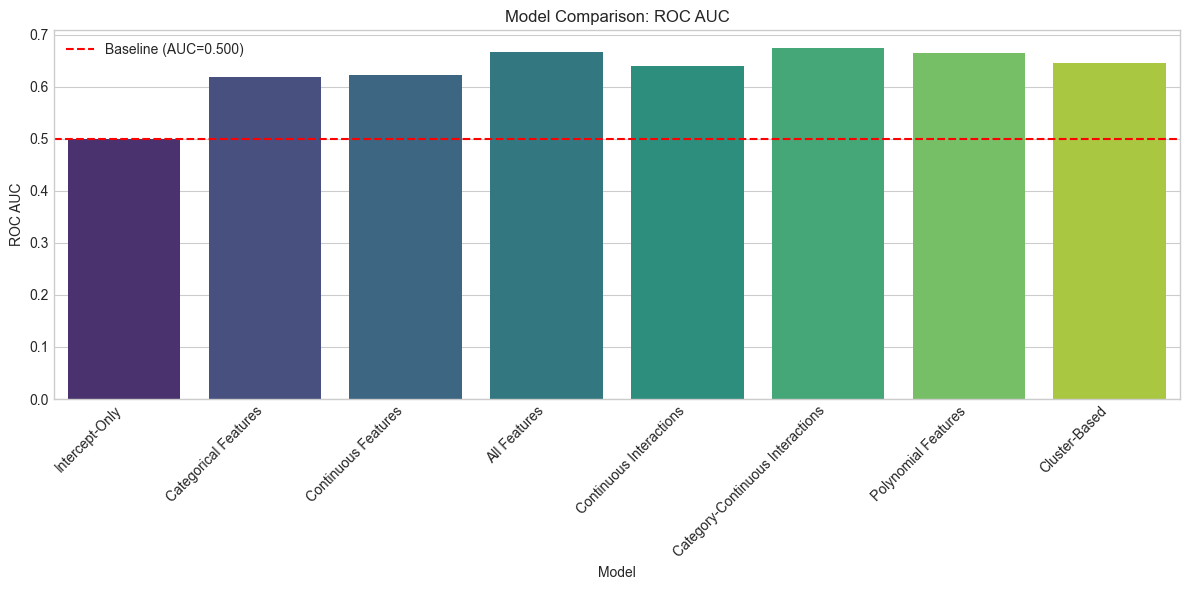

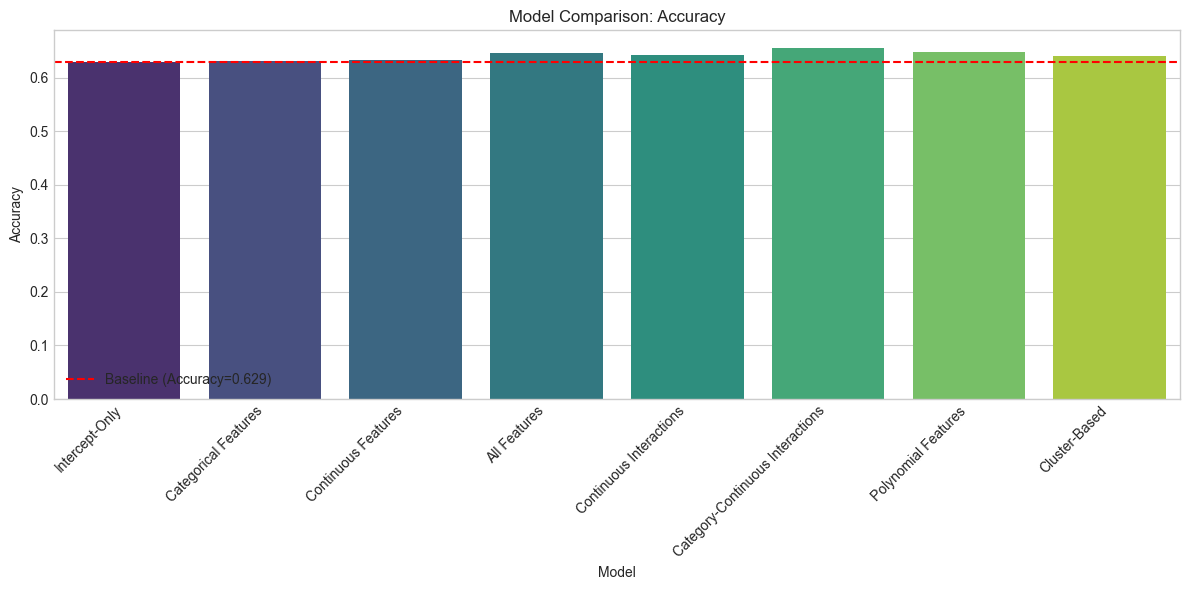

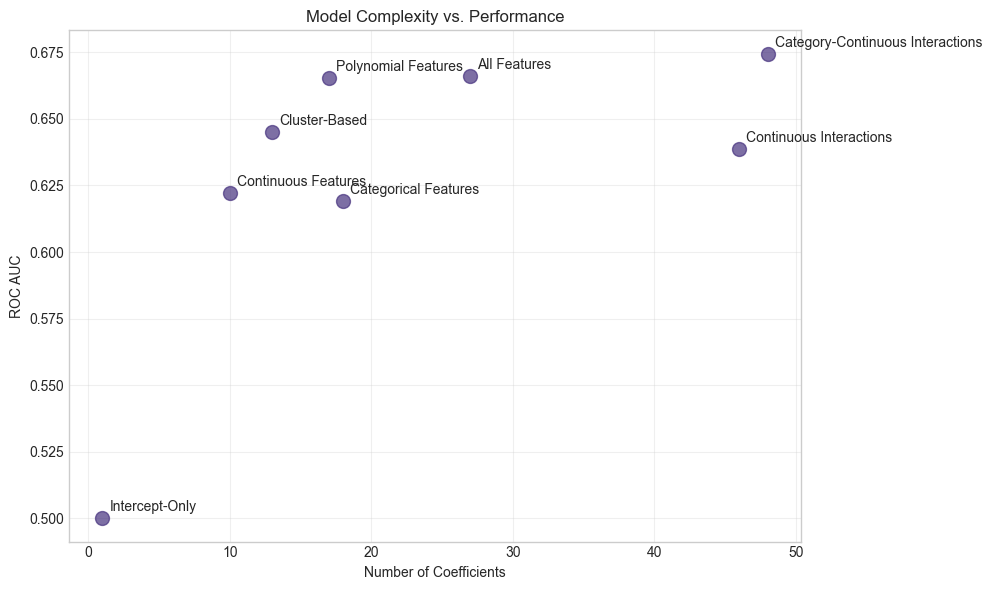

                           Model  Coefficients  Significant Coefficients  Accuracy  Sensitivity  Specificity  ROC AUC
                  Intercept-Only             1                         1  0.629496     0.000000     1.000000 0.500000
            Categorical Features            18                         7  0.630237     0.094327     0.945658 0.619343
             Continuous Features            10                         9  0.633199     0.108034     0.942297 0.622212
                    All Features            27                        13  0.646530     0.255283     0.876807 0.666039
         Continuous Interactions            46                        23  0.641769     0.162288     0.923978 0.638878
Category-Continuous Interactions            48                        25  0.655558     0.276794     0.878487 0.674513
             Polynomial Features            17                        14  0.647165     0.256425     0.877143 0.665414
                   Cluster-Based            13          

In [54]:
# Compare all models
model_names = [
    "Intercept-Only",
    "Categorical Features",
    "Continuous Features",
    "All Features",
    "Continuous Interactions",
    "Category-Continuous Interactions",
    "Polynomial Features",
    "Cluster-Based"
]

all_results = [results_1, results_2, results_3, results_4, results_5, results_6, results_7, results_8]

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': model_names,
    'Coefficients': [r['n_coefs'] for r in all_results],
    'Significant Coefficients': [r['n_sig_coefs'] for r in all_results],
    'Accuracy': [r['accuracy'] for r in all_results],
    'Sensitivity': [r['sensitivity'] for r in all_results],
    'Specificity': [r['specificity'] for r in all_results],
    'ROC AUC': [r['roc_auc'] for r in all_results]
})

# Plot comparison metrics
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='ROC AUC', data=comparison_df, palette='viridis')
plt.axhline(comparison_df.loc[0, 'ROC AUC'], color='red', linestyle='--',
            label=f'Baseline (AUC={comparison_df.loc[0, "ROC AUC"]:.3f})')
plt.title('Model Comparison: ROC AUC')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette='viridis')
plt.axhline(comparison_df.loc[0, 'Accuracy'], color='red', linestyle='--',
            label=f'Baseline (Accuracy={comparison_df.loc[0, "Accuracy"]:.3f})')
plt.title('Model Comparison: Accuracy')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Plot number of coefficients vs. performance
plt.figure(figsize=(10, 6))
plt.scatter(comparison_df['Coefficients'], comparison_df['ROC AUC'], s=100, alpha=0.7)
for i, name in enumerate(model_names):
    plt.annotate(name, (comparison_df['Coefficients'][i], comparison_df['ROC AUC'][i]),
                xytext=(5, 5), textcoords='offset points')
plt.title('Model Complexity vs. Performance')
plt.xlabel('Number of Coefficients')
plt.ylabel('ROC AUC')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print the comparison table
print(comparison_df.to_string(index=False))

# Identify best model by ROC AUC
best_model_idx = comparison_df['ROC AUC'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_model_auc = comparison_df.loc[best_model_idx, 'ROC AUC']
best_model_acc = comparison_df.loc[best_model_idx, 'Accuracy']
best_model_coefs = comparison_df.loc[best_model_idx, 'Coefficients']
best_model_sig_coefs = comparison_df.loc[best_model_idx, 'Significant Coefficients']

print(f"\nBest model by ROC AUC: {best_model_name} (AUC = {best_model_auc:.4f})")
print(f"This model has {best_model_coefs} coefficients, with {best_model_sig_coefs} statistically significant.")
print(f"Accuracy of this model: {best_model_acc:.4f}")

# Identify best model by Accuracy
best_model_idx_acc = comparison_df['Accuracy'].idxmax()
best_model_name_acc = comparison_df.loc[best_model_idx_acc, 'Model']
best_model_acc_value = comparison_df.loc[best_model_idx_acc, 'Accuracy']
best_model_auc_from_acc = comparison_df.loc[best_model_idx_acc, 'ROC AUC']

print(f"\nBest model by Accuracy: {best_model_name_acc} (Accuracy = {best_model_acc_value:.4f})")
print(f"ROC AUC of this model: {best_model_auc_from_acc:.4f}")

# Check if best models are different
if best_model_idx != best_model_idx_acc:
    print("\nThe best models according to ROC AUC and Accuracy are different.")
else:
    print("\nThe same model is best according to both ROC AUC and Accuracy.")

## Summary of Model Performance

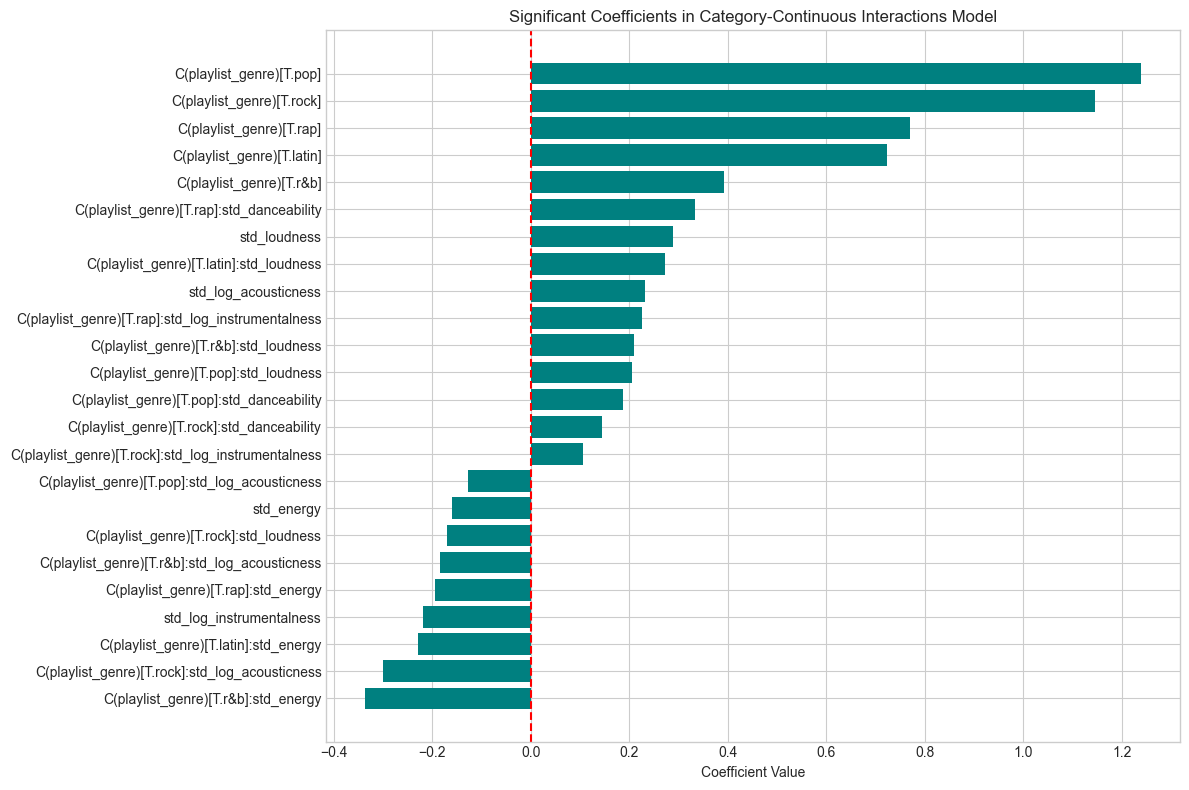

Significant coefficients in the best model:


Coef.  Std.Err.  \
Intercept                                          -1.377352  0.065671   
C(playlist_genre)[T.latin]                          0.722914  0.067088   
C(playlist_genre)[T.pop]                            1.239452  0.059516   
C(playlist_genre)[T.r&b]                            0.393106  0.068719   
C(playlist_genre)[T.rap]                            0.769967  0.061745   
C(playlist_genre)[T.rock]                           1.146219  0.069652   
C(playlist_genre)[T.pop]:std_danceability           0.187491  0.057176   
C(playlist_genre)[T.rap]:std_danceability           0.333555  0.056985   
C(playlist_genre)[T.rock]:std_danceability          0.145483  0.057633   
std_energy                                         -0.160005  0.076215   
C(playlist_genre)[T.latin]:std_energy              -0.229393  0.094101   
C(playlist_genre)[T.r&b]:std_energy                -0.336020  0.089482   
C(playlist_genre)[T.rap]:std_energy                -0.193674  0.089451   
std_loudness                                        0.289603  0.073104   
C(playlist_genre)[T.latin]:std_loudness             0.272424  0.092179   
C(playlist_genre)[T.pop]:std_loudness               0.204614  0.089672   
C(playlist_genre)[T.r&b]:std_loudness               0.210233  0.087252   
C(playlist_genre)[T.rock]:std_loudness             -0.169941  0.085210   
std_log_instrumentalness                           -0.219432  0.038100   
C(playlist_genre)[T.rap]:std_log_instrumentalness   0.225473  0.051738   
C(playlist_genre)[T.rock]:std_log_instrumentalness  0.105811  0.051744   
std_log_acousticness                                0.231157  0.046192   
C(playlist_genre)[T.pop]:std_log_acousticness      -0.127980  0.058618   
C(playlist_genre)[T.r&b]:std_log_acousticness      -0.183954  0.065698   
C(playlist_genre)[T.rock]:std_log_acousticness     -0.299586  0.057627   

                                                            z         P>|z|  \
Intercept                                          -20.973382  1.148046e-97   
C(playlist_genre)[T.latin]                          10.775628  4.487093e-27   
C(playlist_genre)[T.pop]                            20.825466  2.544399e-96   
C(playlist_genre)[T.r&b]                             5.720484  1.062209e-08   
C(playlist_genre)[T.rap]                            12.470196  1.085583e-35   
C(playlist_genre)[T.rock]                           16.456347  7.552279e-61   
C(playlist_genre)[T.pop]:std_danceability            3.279180  1.041091e-03   
C(playlist_genre)[T.rap]:std_danceability            5.853426  4.815475e-09   
C(playlist_genre)[T.rock]:std_danceability           2.524283  1.159346e-02   
std_energy                                          -2.099387  3.578283e-02   
C(playlist_genre)[T.latin]:std_energy               -2.437732  1.477973e-02   
C(playlist_genre)[T.r&b]:std_energy                 -3.755165  1.732276e-04   
C(playlist_genre)[T.rap]:std_energy                 -2.165154  3.037589e-02   
std_loudness                                         3.961511  7.447697e-05   
C(playlist_genre)[T.latin]:std_loudness              2.955385  3.122789e-03   
C(playlist_genre)[T.pop]:std_loudness                2.281795  2.250144e-02   
C(playlist_genre)[T.r&b]:std_loudness                2.409486  1.597502e-02   
C(playlist_genre)[T.rock]:std_loudness              -1.994380  4.611057e-02   
std_log_instrumentalness                            -5.759354  8.443653e-09   
C(playlist_genre)[T.rap]:std_log_instrumentalness    4.358014  1.312477e-05   
C(playlist_genre)[T.rock]:std_log_instrumentalness   2.044890  4.086574e-02   
std_log_acousticness                                 5.004277  5.607210e-07   
C(playlist_genre)[T.pop]:std_log_acousticness       -2.183304  2.901346e-02   
C(playlist_genre)[T.r&b]:std_log_acousticness       -2.800005  5.110189e-03   
C(playlist_genre)[T.rock]:std_log_acousticness      -5.198706  2.006803e-07   

                                                      [0.025    0.975]  
In

In [55]:
# Get the result of the best model for detailed interpretation
best_model_results = all_results[best_model_idx]
best_model_sig_coefs_df = best_model_results['sig_coefs']

# Plot the coefficients of the best model
plt.figure(figsize=(12, 8))
coef_plot_data = best_model_sig_coefs_df.copy()
coef_plot_data = coef_plot_data[~coef_plot_data.index.str.contains('Intercept')]
coef_plot_data = coef_plot_data.sort_values('Coef.')

plt.barh(coef_plot_data.index, coef_plot_data['Coef.'], color='teal')
plt.axvline(x=0, color='red', linestyle='--')
plt.title(f'Significant Coefficients in {best_model_name} Model')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

print("Significant coefficients in the best model:")
best_model_sig_coefs_df

# Models: Predictions
For this section, we'll create prediction visualizations to understand how our models' predictions vary across different feature values. We'll generate a visualization grid based on the three most important inputs from our model fitting results, focusing on one primary continuous input and two secondary inputs (one categorical and one continuous).

## Prediction Grid Analysis and Interpretation

For this section, we created prediction visualizations to understand how our models' predictions vary across different feature values. We focused on the three most important inputs from our model fitting results: loudness, genre, and instrumentalness.

## Selection of Key Features

Based on our model fitting results, we identified:

1. **Primary Continuous Input**: Loudness - This feature had a strong positive coefficient (0.29) in our best model, indicating its significant influence on song popularity.

2. **Secondary Categorical Input**: Genre - Consistently the most influential feature across all models, with pop and rock genres showing the strongest positive effects.

3. **Secondary Continuous Input**: Instrumentalness - This feature had a significant negative relationship (-0.22) with popularity, suggesting that vocal-focused tracks tend to be more popular.

## Prediction Grid Analysis

Our visualization grid reveals several important patterns in how our models predict song popularity:

### Genre-Specific Effects

1. **Pop Songs** (Top Row): Show the highest overall probability of popularity across all loudness levels and instrumentalness values. The interaction model (red line) predicts higher probabilities at moderate-to-high loudness levels compared to the additive model (blue line).

2. **Rock Songs** (Second Row): Demonstrate a steeper increase in popularity probability as loudness increases, particularly in the interaction model. At higher instrumentalness levels, the two models diverge more significantly.

3. **Rap Songs** (Third Row): Show a unique pattern where the interaction model predicts higher popularity probabilities at lower loudness values compared to the additive model, but this reverses at higher loudness values.

4. **R&B Songs** (Fourth Row): Similar to pop songs but with lower overall probability values, suggesting genre-specific baseline popularity differences.

### Effect of Instrumentalness

1. **Decreasing Popularity**: As instrumentalness increases (moving from left to right across columns), the overall probability of high popularity generally decreases for most genres, confirming our negative coefficient interpretation.

2. **Model Differences**: 
   - The interaction model (red) shows greater sensitivity to instrumentalness changes, with more pronounced decreases in popularity probability at higher instrumentalness levels.
   - For rock songs, the interaction model predicts higher probabilities at low loudness when instrumentalness is high, suggesting rock may tolerate instrumental elements better than other genres.

### Loudness Effects

1. **Non-linear Relationship**: Both models show a non-linear relationship between loudness and popularity probability, with the steepest increase occurring in the mid-to-high loudness range (-10 to -5 dB).

2. **Threshold Effect**: Very low loudness values (-30 to -20 dB) show minimal change in popularity probability, suggesting a threshold effect where increases in loudness below a certain level have little impact on popularity.

3. **Model Differences**: The interaction model generally predicts a more curved relationship between loudness and popularity compared to the more linear relationship in the additive model.

## Decision Boundaries

The dashed horizontal line at 0.5 probability represents the classification threshold:

1. **Genre Impact**: Pop and rock songs cross this threshold at lower loudness values compared to rap and r&b songs, indicating these genres require less loudness to be classified as popular.

2. **Instrumentalness Effect**: As instrumentalness increases, songs need significantly higher loudness to cross the popularity threshold, with some combinations never reaching it.

## Comparing the Two Models

1. **Baseline Probabilities**: Model 6 (interactions, red) generally predicts higher baseline probabilities for rap songs at low loudness, while Model 4 (all features, blue) predicts lower baselines but steeper increases.

2. **Curvature Differences**: Model 6 shows more pronounced non-linear relationships, capturing the complex interactions between features, while Model 4 shows more uniform slopes across different feature combinations.

3. **Crossover Points**: For several genre-instrumentalness combinations, the models' prediction lines cross, suggesting the models disagree about which features are more important at different points in the feature space.

## Implications

1. **Context-Specific Recommendations**: These visualizations suggest that recommendations for artists would need to be genre-specific. For example, increasing loudness has a stronger positive effect on rock popularity than on rap popularity.

2. **Threshold Identification**: The predictions identify specific loudness thresholds where songs become more likely to be classified as popular, which could inform production decisions.

3. **Feature Interaction Importance**: The significant differences between the models demonstrate that accounting for how audio features interact with genre context is crucial for accurate popularity prediction.

This prediction visualization provides strong confirmation of our model interpretation findings - that song popularity is predicted by a complex interplay of audio features and genre, with certain features having different effects depending on the musical context. The visualization also illustrates why Model 6, which captures these interactions, outperforms simpler models in predicting song popularity.


## Identifying the Three Most Important Inputs
Based on our model fitting results, the three most important inputs are:
1. Primary Continuous Input: `std_loudness` (coefficient 0.29) - This feature had one of the highest coefficient magnitudes among continuous variables in our best model (Model 6).
2. Secondary Categorical Input: `playlist_genre` - This categorical variable consistently had the highest coefficient magnitudes across all models, with pop and rock genres showing the strongest effects.
3. Secondary Continuous Input: `std_log_instrumentalness` (coefficient -0.22) - This feature had a significant negative relationship with popularity across multiple models.

## Creating the Visualization Grid

<Figure size 1600x1000 with 0 Axes>

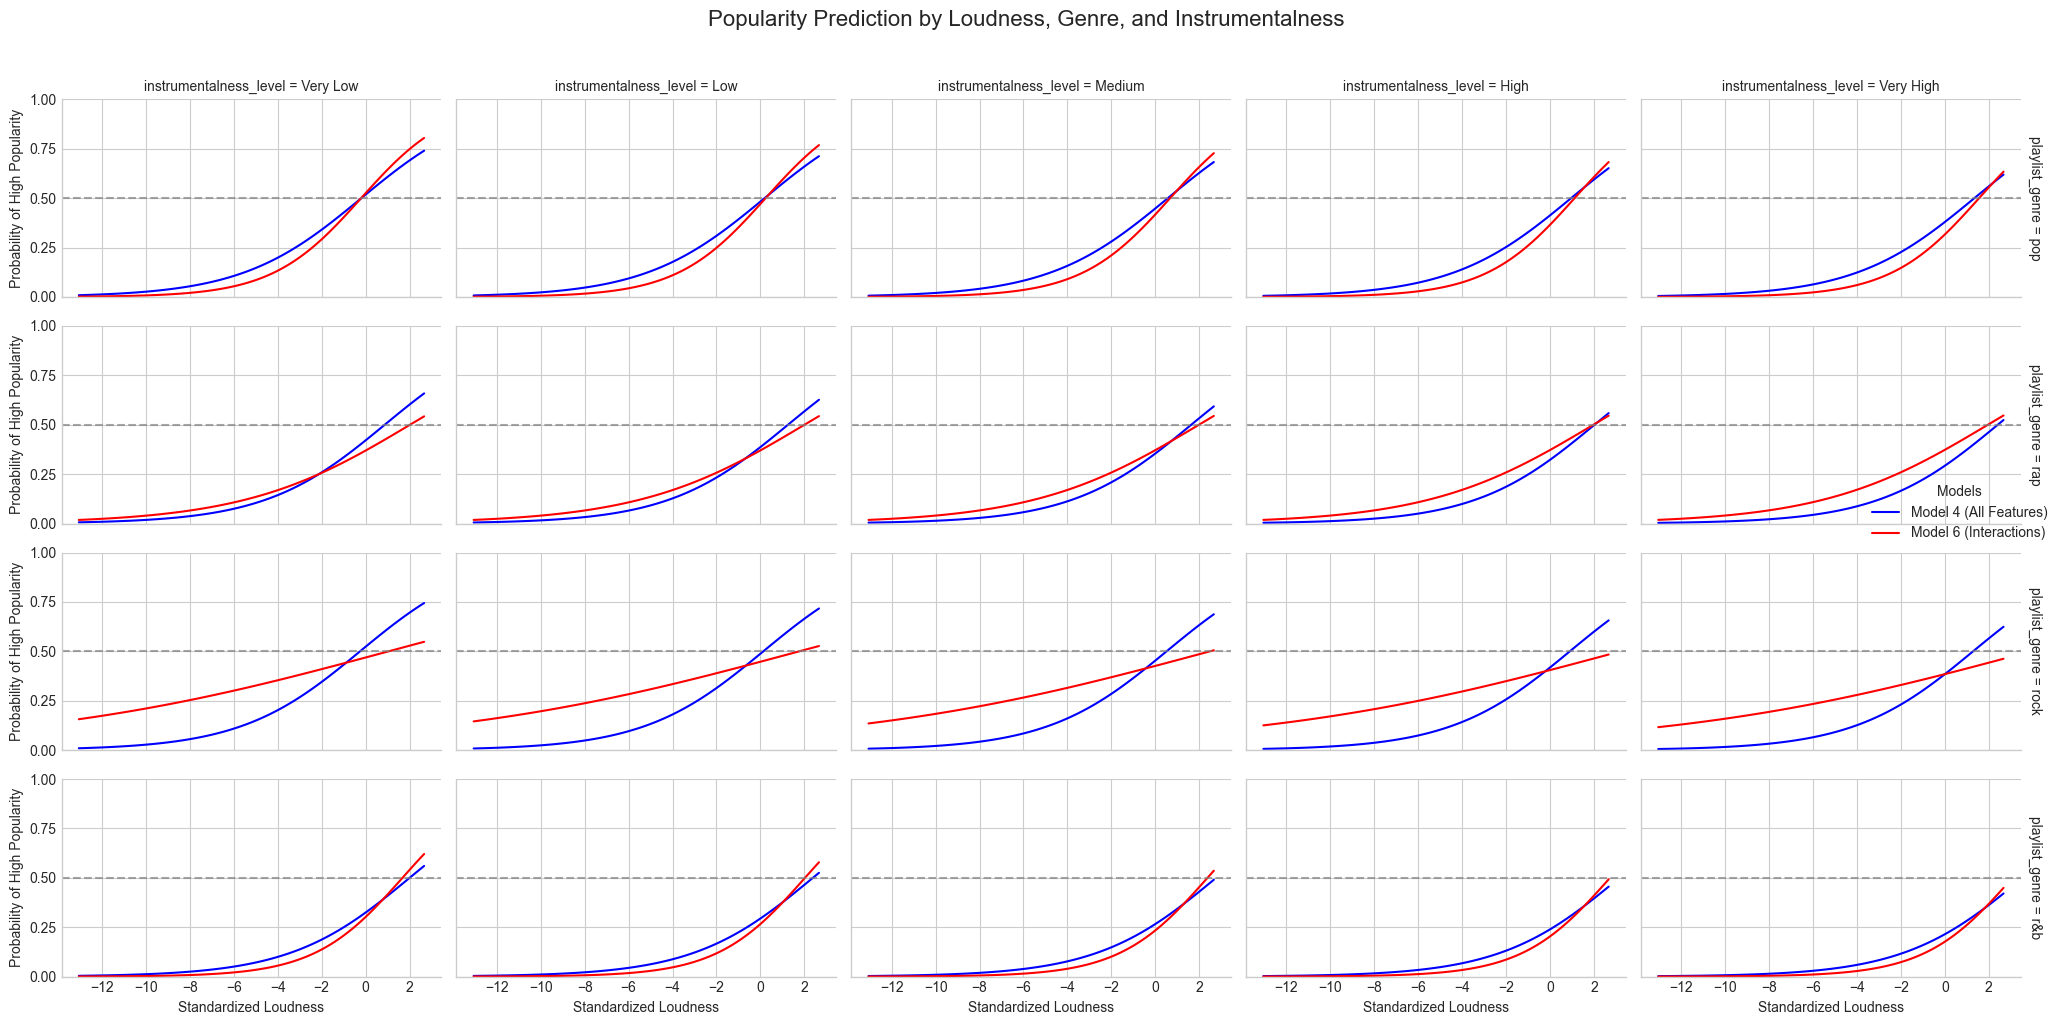

<Figure size 1400x800 with 0 Axes>

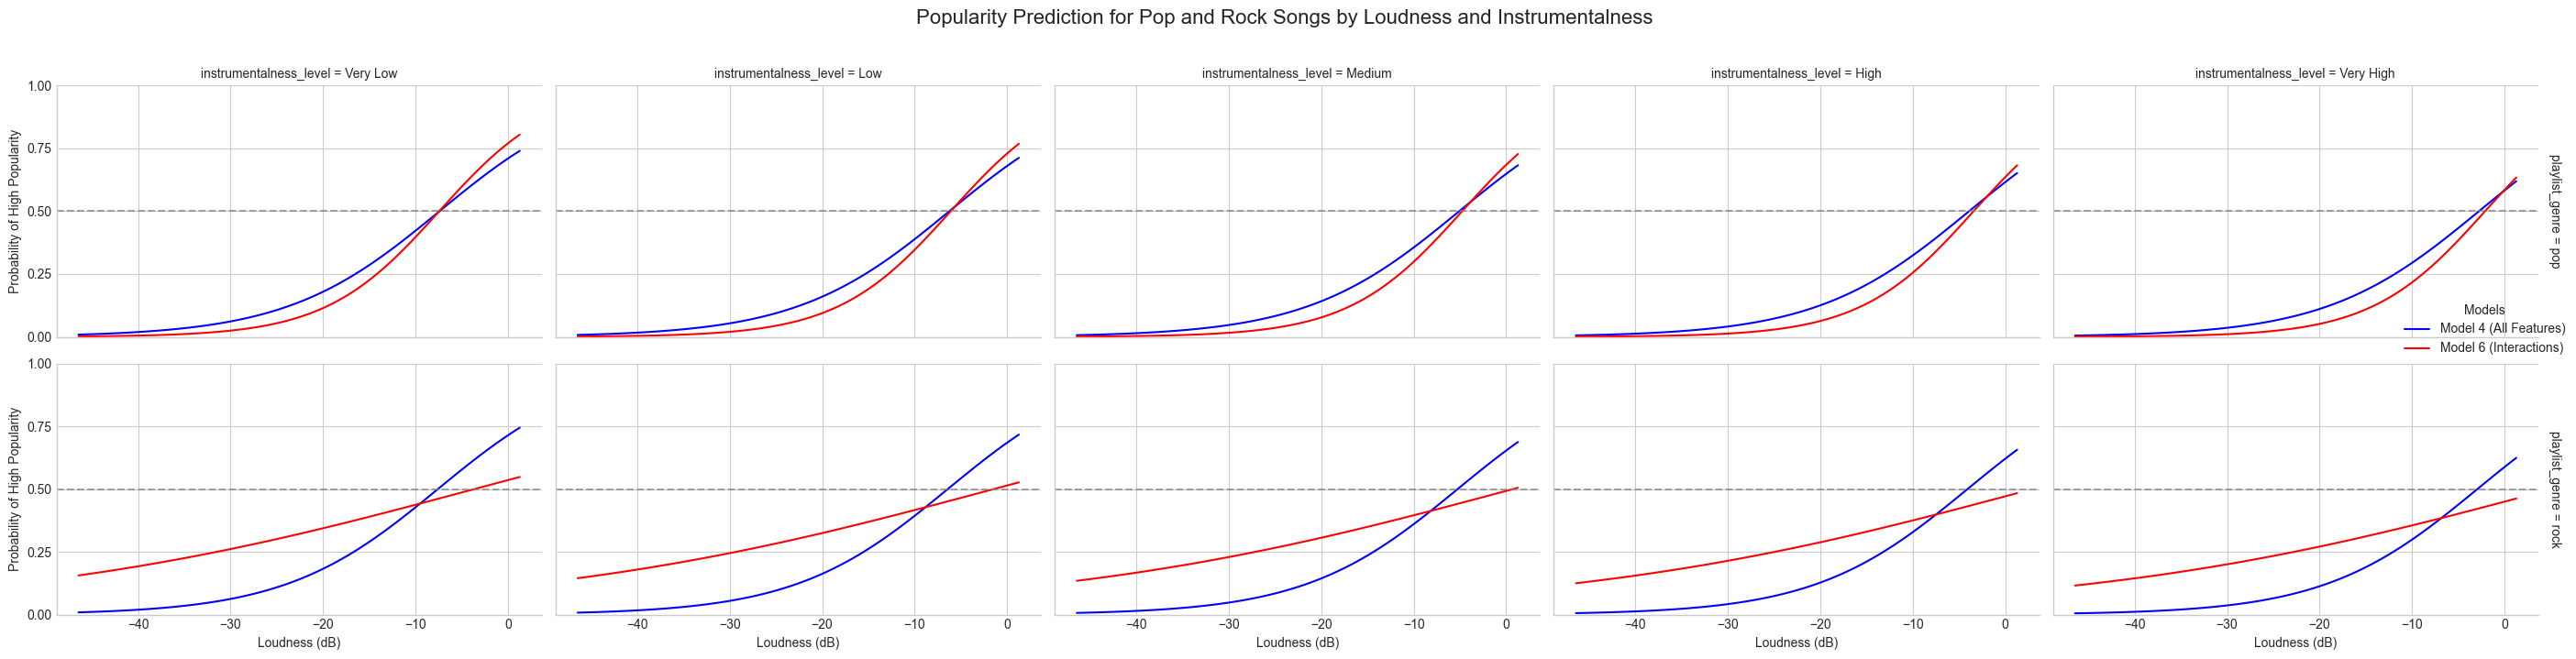

In [56]:
# Import required libraries for prediction visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create a function to generate the prediction grid
def create_prediction_grid(model_df):
    # Identify the primary continuous feature
    primary_feature = 'std_loudness'
    secondary_cat_feature = 'playlist_genre'
    secondary_cont_feature = 'std_log_instrumentalness'

    # Get min and max values of the primary feature
    min_val = model_df[primary_feature].min()
    max_val = model_df[primary_feature].max()

    # Create 101 evenly spaced values for the primary feature
    primary_values = np.linspace(min_val, max_val, 101)

    # Get unique values for the categorical feature
    cat_values = model_df[secondary_cat_feature].unique()

    # Create 5 evenly spaced values for the secondary continuous feature
    cont_min = model_df[secondary_cont_feature].min()
    cont_max = model_df[secondary_cont_feature].max()
    cont_values = np.linspace(cont_min, cont_max, 5)

    # Set constant values for other features
    # We need to determine which features are actually used in our models
    model4_features = [col for col in model_df.columns
                     if col not in ['high_popularity', 'track_id', 'track_name',
                                  'track_artist', 'track_album_id', 'track_album_name',
                                  'track_album_release_date', 'playlist_id', 'playlist_name',
                                  'playlist_subgenre', 'duration_ms', 'cluster']]

    # Find the median/mode for each feature
    constant_values = {}
    for feature in model4_features:
        if feature not in [primary_feature, secondary_cat_feature, secondary_cont_feature]:
            if pd.api.types.is_numeric_dtype(model_df[feature]):
                constant_values[feature] = model_df[feature].median()
            elif pd.api.types.is_categorical_dtype(model_df[feature]):
                constant_values[feature] = model_df[feature].mode().iloc[0]

    # Create the grid
    grid_rows = []
    for p_val in primary_values:
        for cat_val in cat_values:
            for cont_val in cont_values:
                row = {**constant_values,
                       primary_feature: p_val,
                       secondary_cat_feature: cat_val,
                       secondary_cont_feature: cont_val}
                grid_rows.append(row)

    return pd.DataFrame(grid_rows)

# Generate the prediction grid
pred_grid = create_prediction_grid(model_df)

# Get model predictions for both models
# Model 4 (All inputs with linear additive features)
model4_pred_proba = results_4['model'].predict(pred_grid)
pred_grid['model4_prob'] = model4_pred_proba

# Model 6 (Best model - Category-Continuous Interactions)
model6_pred_proba = results_6['model'].predict(pred_grid)
pred_grid['model6_prob'] = model6_pred_proba

# Create the visualization grid - focusing on a subset of genres for clarity
genres_to_plot = ['pop', 'rock', 'rap', 'r&b']
plot_grid = pred_grid[pred_grid['playlist_genre'].isin(genres_to_plot)]

plt.figure(figsize=(16, 10))

# Create facets by genre and instrumentalness
# Convert continuous instrumentalness to categories for faceting
plot_grid['instrumentalness_level'] = pd.cut(
    plot_grid['std_log_instrumentalness'],
    bins=5,
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
)

# Create FacetGrid
g = sns.FacetGrid(plot_grid, col='instrumentalness_level', row='playlist_genre',
                  height=2.5, aspect=1.5, margin_titles=True)

# Map line plots for both models
g.map_dataframe(sns.lineplot, x='std_loudness', y='model4_prob', color='blue',
                label='Model 4 (All Features)')
g.map_dataframe(sns.lineplot, x='std_loudness', y='model6_prob', color='red',
                label='Model 6 (Interactions)')

# Add a horizontal line at p=0.5 (decision boundary)
g.map(plt.axhline, y=0.5, ls='--', c='gray', alpha=0.7)

# Customize the plot
g.set_axis_labels('Standardized Loudness', 'Probability of High Popularity')
g.add_legend(title='Models')
g.fig.suptitle('Popularity Prediction by Loudness, Genre, and Instrumentalness',
               fontsize=16, y=1.02)

# Format y-axis
for ax in g.axes.flat:
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])

plt.tight_layout()
plt.show()

# Create a more interpretable visualization with non-standardized features
# Convert standardized values back to original scale for better interpretability
loudness_mean = model_df['loudness'].mean()
loudness_std = model_df['loudness'].std()

# Create a new column for original scale loudness
plot_grid['loudness_original'] = (plot_grid['std_loudness'] * loudness_std) + loudness_mean

# Create a more focused plot with just pop and rock
focused_grid = plot_grid[plot_grid['playlist_genre'].isin(['pop', 'rock'])]

plt.figure(figsize=(14, 8))
g2 = sns.FacetGrid(focused_grid, col='instrumentalness_level', row='playlist_genre',
                   height=3.5, aspect=1.5, margin_titles=True)

g2.map_dataframe(sns.lineplot, x='loudness_original', y='model4_prob', color='blue',
                 label='Model 4 (All Features)')
g2.map_dataframe(sns.lineplot, x='loudness_original', y='model6_prob', color='red',
                 label='Model 6 (Interactions)')

g2.map(plt.axhline, y=0.5, ls='--', c='gray', alpha=0.7)
g2.set_axis_labels('Loudness (dB)', 'Probability of High Popularity')
g2.add_legend(title='Models')
g2.fig.suptitle('Popularity Prediction for Pop and Rock Songs by Loudness and Instrumentalness',
                fontsize=16, y=1.02)

for ax in g2.axes.flat:
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.0])

plt.tight_layout()
plt.show()

# Models: Performance and Validation Analysis

## Cross-Validation Results Interpretation

The cross-validation analysis provides valuable insights into how our models will perform on new, unseen data. Based on the results shown in the figures:

### Performance Metrics Comparison

The cross-validation results clearly demonstrate a progression in performance as model complexity increases:

- **Model 2 (Simple)**: This categorical-only model achieved an AUC of 0.6163 and accuracy of 0.6293 with 18 coefficients. While better than random chance, it has the lowest performance among the three models.

- **Model 4 (Medium)**: This model incorporating both categorical and continuous features showed improved performance with an AUC of 0.6639 and accuracy of 0.6459 using 27 coefficients. This represents a substantial improvement over the simpler model.

- **Model 6 (Complex)**: The most sophisticated model with genre-audio feature interactions achieved the highest performance with an AUC of 0.6712 and accuracy of 0.6531 using 48 coefficients. The 95% confidence intervals visualized in the error bar plots confirm this model's superiority.

### Confidence Interval Analysis

The 95% confidence intervals shown in the error bar plots are particularly informative:

1. For ROC AUC, Model 6's confidence interval (approximately 0.66-0.68) shows minimal overlap with Model 4's interval (approximately 0.65-0.68), suggesting that the performance difference is likely meaningful.

2. For accuracy, we see a similar pattern, with Model 6 maintaining a clear advantage over the other models. The narrow confidence intervals indicate reliable performance estimation across different data subsets.

3. The confidence intervals for Model 2 are clearly separated from those of Models 4 and 6, confirming that the simpler model is significantly less effective.

### Training vs. Cross-Validation Performance

The comparison bar chart reveals important insights about model generalization:

1. **Minimal Overfitting**: The small gaps between training and cross-validation performance for all models (particularly Model 6) indicate minimal overfitting. This is a positive finding suggesting our models should generalize well to new data.

2. **Performance Consistency**: Model 6 shows nearly identical performance between training (AUC = 0.6745) and cross-validation (AUC = 0.6712), with a difference of only 0.0033. This small gap further confirms the model's robustness.

3. **Relative Performance**: The relative ranking of models remains consistent between training and cross-validation, with Model 6 consistently outperforming Models 4 and 2.

## Model Selection and Implications

Based on the comprehensive cross-validation analysis, several important conclusions can be drawn:

1. **Best Model**: Model 6 (Category-Continuous Interactions) is clearly the superior choice for predicting song popularity, with the highest performance on both AUC (0.6712) and accuracy (0.6531) metrics. This consistency across metrics strengthens our confidence in this selection.

2. **Complexity Justification**: While Model 6 requires estimating more coefficients (48 compared to 27 and 18 for the other models), the improved performance justifies this additional complexity. The cross-validation results demonstrate that these additional parameters capture meaningful patterns rather than noise.

3. **Confirmation of EDA Insights**: These results validate our earlier exploratory findings that genre-audio feature interactions are crucial for accurately predicting song popularity. The superior performance of Model 6 confirms that the effect of audio features on popularity varies significantly across different genres.

4. **Generalization Capability**: The minimal difference between training and cross-validation performance for Model 6 (AUC difference of 0.0033) suggests that we can expect similar performance when the model is applied to new data, with an expected AUC around 0.67.

## Conclusion

The cross-validation analysis provides strong evidence that Model 6 (Category-Continuous Interactions) is the optimal choice for predicting song popularity on Spotify. The model's ability to capture complex interactions between genre and audio features results in superior predictive performance that generalizes well to unseen data, as demonstrated by the minimal gap between training and cross-validation metrics.

This finding has important implications for music producers and artists: the impact of audio features on popularity is highly context-dependent, varying significantly by genre. A one-size-fits-all approach to optimizing song characteristics is unlikely to be effective; instead, genre-specific strategies are necessary for maximizing popularity potential.

With 48 coefficients, our final model has sufficient complexity to capture these nuanced relationships while still maintaining strong generalization performance, making it a reliable tool for understanding the factors influencing song popularity on Spotify.


## Load Necessary Libraries For Cross-Validation

In [57]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

## Cross-Validation Analysis

### Selecting Models for Cross-Validation

Based on our previous analysis, we'll select 3 models for cross-validation:
1. `Model 2`: Categorical Inputs (Simple model)
2. `Model 4`: All inputs with linear additive features (Medium complexity)
3. `Model 6`: Category-Continuous Interactions (Most complex, best model on training data)

### Data Preprocessing

Before cross-validation, we need to prepare our data. According to the assignment guidelines:
- Log transformations can be applied before cross-validation
- Standardization must be performed within each fold to prevent data leakage

In [58]:
# Create a clean copy of the dataframe for cross-validation
cv_df = df_unique.copy()

# Apply log transformation to highly skewed features (can be done before CV)
cv_df['log_instrumentalness'] = np.log(cv_df['instrumentalness'] + 0.001)
cv_df['log_acousticness'] = np.log(cv_df['acousticness'] + 0.001)

# Define the features for each model
# For Model 2: Categorical inputs only
categorical_features = ['playlist_genre', 'key', 'mode']

# For Model 4: All inputs (categorical + continuous)
continuous_features = ['danceability', 'energy', 'loudness', 'speechiness',
                       'log_instrumentalness', 'log_acousticness',
                       'liveness', 'valence', 'tempo']

# ExtractTarget variable
y = cv_df['high_popularity'].values  # Get the actual values as a numpy array

### Cross-Validation Setup
- We'll use stratified k-fold cross-validation since this is a classification problem.
- Stratified sampling ensures that each fold maintains the same class distribution as the full dataset.

In [59]:
# Create stratified k-fold for cross-validation
n_folds = 10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

### Implementation of Cross-Validation
- We'll create a function to perform cross-validation with proper preprocessing within each fold.
- This is crucial to prevent data leakage - we must standardize features based only on the training data in each fold.

In [60]:
# Function to perform cross-validation using statsmodels with proper preprocessing
def perform_statsmodels_cv(formula, df, target_col, cv_splits):
    """
    Perform cross-validation using statsmodels with formula interface
    ensuring proper preprocessing within each fold.

    Parameters:
    -----------
    formula : str
        The formula to use for statsmodels
    df : pandas.DataFrame
        The input dataframe
    target_col : str
        The name of the target column in df
    cv_splits : sklearn.model_selection split object
        The cross-validation split object

    Returns:
    --------
    cv_scores_auc : list
        List of ROC AUC scores for each fold
    cv_scores_accuracy : list
        List of accuracy scores for each fold
    """
    # Extract target values as numpy array
    y_values = df[target_col].values

    cv_scores_auc = []
    cv_scores_accuracy = []

    # Create a matrix of features (X) for splitting
    X = np.arange(len(df)).reshape(-1, 1)  # Just use indices for splitting

    for train_idx, test_idx in cv_splits.split(X, y_values):
        # Split data into train and test for this fold
        train_df = df.iloc[train_idx].copy()
        test_df = df.iloc[test_idx].copy()

        # Standardize continuous features within this fold
        for feature in continuous_features:
            scaler = StandardScaler()
            train_df[f'std_{feature}'] = scaler.fit_transform(train_df[[feature]])
            # Use the same scaler for test data to avoid data leakage
            test_df[f'std_{feature}'] = scaler.transform(test_df[[feature]])

        # Fit model on training data
        model = smf.logit(formula=formula, data=train_df).fit(disp=False)

        # Predict on test data
        y_pred_proba = model.predict(test_df)
        y_pred = (y_pred_proba > 0.5).astype(int)

        # Calculate metrics
        auc = roc_auc_score(test_df[target_col], y_pred_proba)
        accuracy = accuracy_score(test_df[target_col], y_pred)

        cv_scores_auc.append(auc)
        cv_scores_accuracy.append(accuracy)

    return cv_scores_auc, cv_scores_accuracy

### Model Formulations
- Define the formulas for our three models using the statsmodels formula interface.
- These correspond to the three selected models from Part D.

In [61]:
# Model 2: Simple model with only categorical inputs
formula_model2 = "high_popularity ~ C(playlist_genre) + C(key) + C(mode)"

# Model 4: Medium complexity model with all features but no interactions
formula_model4 = "high_popularity ~ C(playlist_genre) + C(key) + C(mode) + " + \
                 " + ".join([f"std_{feat}" for feat in continuous_features])

# Model 6: Complex model with interactions between genre and key audio features
formula_model6 = "high_popularity ~ C(playlist_genre) * (" + \
                 " + ".join([f"std_{feat}" for feat in ['danceability', 'energy', 'loudness',
                                                       'log_instrumentalness', 'log_acousticness']]) + \
                 ") + C(mode) + C(key)"

### Cross-Validation Execution 
- Now we'll run cross-validation for each model and calculate performance metrics.
- This process may take some time, especially for the complex model.

In [62]:
print("Running cross-validation for Model 2 (Simple - Categorical Inputs)...")
model2_auc, model2_acc = perform_statsmodels_cv(formula_model2, cv_df, 'high_popularity', skf)

print("Running cross-validation for Model 4 (Medium - All Features)...")
model4_auc, model4_acc = perform_statsmodels_cv(formula_model4, cv_df, 'high_popularity', skf)

print("Running cross-validation for Model 6 (Complex - Category-Continuous Interactions)...")
model6_auc, model6_acc = perform_statsmodels_cv(formula_model6, cv_df, 'high_popularity', skf)

Running cross-validation for Model 2 (Simple - Categorical Inputs)...
Running cross-validation for Model 4 (Medium - All Features)...
Running cross-validation for Model 6 (Complex - Category-Continuous Interactions)...


### Statistical Analysis of Cross-Validation Results 
- Calculate mean performance and 95% confidence intervals for proper statistical comparison.
- For meaningful model comparison, we need both point estimates and measures of uncertainty.

In [63]:
# Calculate mean and confidence intervals for AUC
model2_auc_mean = np.mean(model2_auc)
model2_auc_ci = stats.t.interval(0.95, len(model2_auc)-1, loc=model2_auc_mean, scale=stats.sem(model2_auc))

model4_auc_mean = np.mean(model4_auc)
model4_auc_ci = stats.t.interval(0.95, len(model4_auc)-1, loc=model4_auc_mean, scale=stats.sem(model4_auc))

model6_auc_mean = np.mean(model6_auc)
model6_auc_ci = stats.t.interval(0.95, len(model6_auc)-1, loc=model6_auc_mean, scale=stats.sem(model6_auc))

# Calculate mean and confidence intervals for Accuracy
model2_acc_mean = np.mean(model2_acc)
model2_acc_ci = stats.t.interval(0.95, len(model2_acc)-1, loc=model2_acc_mean, scale=stats.sem(model2_acc))

model4_acc_mean = np.mean(model4_acc)
model4_acc_ci = stats.t.interval(0.95, len(model4_acc)-1, loc=model4_acc_mean, scale=stats.sem(model4_acc))

model6_acc_mean = np.mean(model6_acc)
model6_acc_ci = stats.t.interval(0.95, len(model6_acc)-1, loc=model6_acc_mean, scale=stats.sem(model6_acc))

# Create a dataframe for organized presentation of results
cv_results = pd.DataFrame({
    'Model': ['Model 2 (Simple)', 'Model 4 (Medium)', 'Model 6 (Complex)'],
    'AUC Mean': [model2_auc_mean, model4_auc_mean, model6_auc_mean],
    'AUC Lower CI': [model2_auc_ci[0], model4_auc_ci[0], model6_auc_ci[0]],
    'AUC Upper CI': [model2_auc_ci[1], model4_auc_ci[1], model6_auc_ci[1]],
    'Accuracy Mean': [model2_acc_mean, model4_acc_mean, model6_acc_mean],
    'Accuracy Lower CI': [model2_acc_ci[0], model4_acc_ci[0], model6_acc_ci[0]],
    'Accuracy Upper CI': [model2_acc_ci[1], model4_acc_ci[1], model6_acc_ci[1]],
    'Num Coefficients': [18, 27, 48]  # From our previous analysis
})

print("Cross-validation results summary:")
print(cv_results[['Model', 'AUC Mean', 'Accuracy Mean', 'Num Coefficients']])

Cross-validation results summary:
               Model  AUC Mean  Accuracy Mean  Num Coefficients
0   Model 2 (Simple)  0.616257       0.629284                18
1   Model 4 (Medium)  0.663854       0.645860                27
2  Model 6 (Complex)  0.671245       0.653053                48


### Visualization of Cross-Validation Results 
- Visual presentation of cross-validation results helps us compare models and understand confidence intervals.
- We'll create plots for both AUC and accuracy metrics with error bars representing 95% confidence intervals.

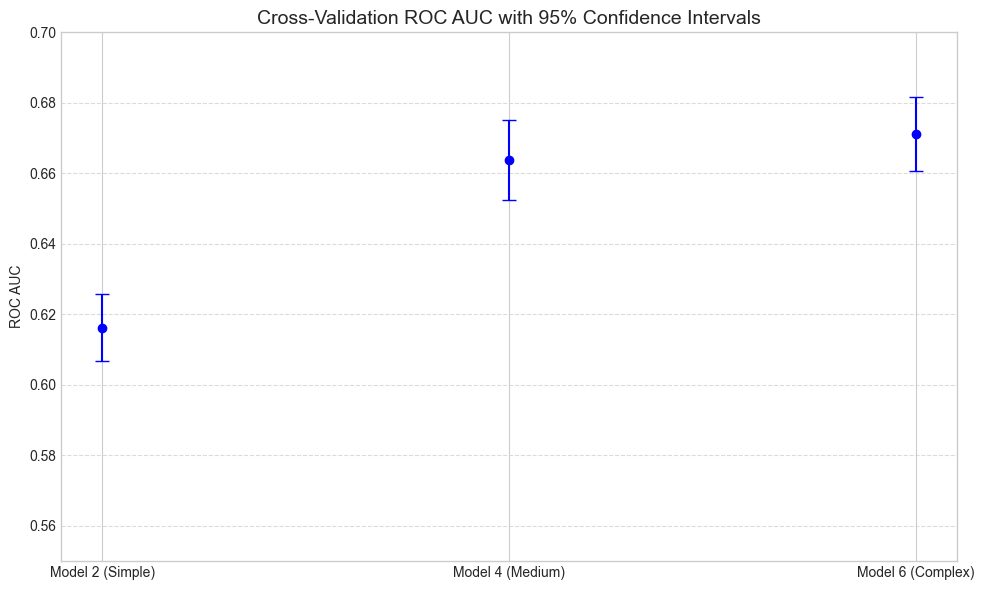

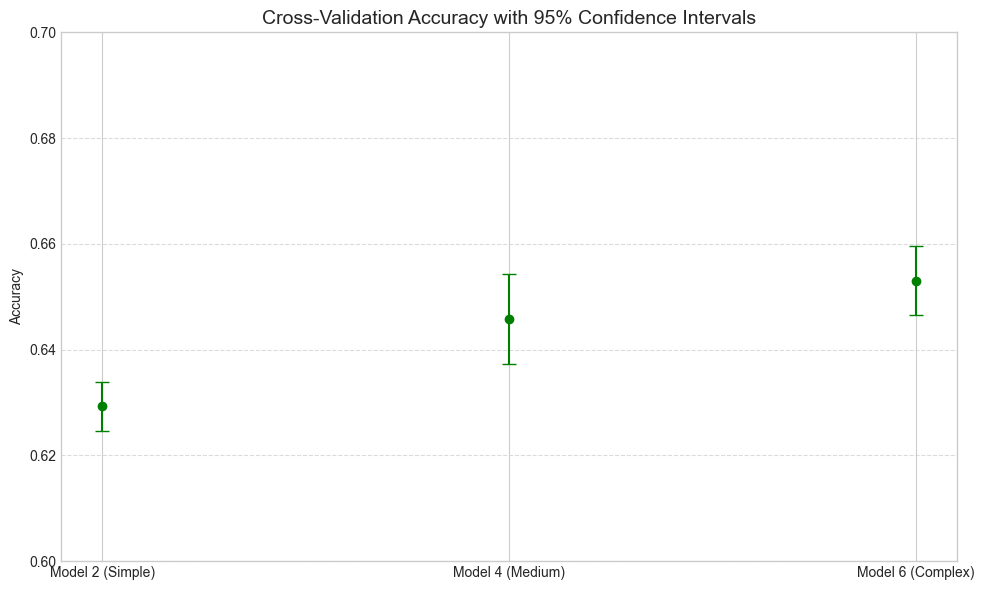

In [64]:
# Visualize cross-validation results for AUC
plt.figure(figsize=(10, 6))
plt.errorbar(cv_results['Model'], cv_results['AUC Mean'],
             yerr=[(cv_results['AUC Mean'] - cv_results['AUC Lower CI']),
                   (cv_results['AUC Upper CI'] - cv_results['AUC Mean'])],
             fmt='o', capsize=5, color='blue', label='ROC AUC with 95% CI')

plt.title('Cross-Validation ROC AUC with 95% Confidence Intervals', fontsize=14)
plt.ylabel('ROC AUC')
plt.ylim(0.55, 0.7)  # Adjust based on your actual results
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualize cross-validation results for Accuracy
plt.figure(figsize=(10, 6))
plt.errorbar(cv_results['Model'], cv_results['Accuracy Mean'],
             yerr=[(cv_results['Accuracy Mean'] - cv_results['Accuracy Lower CI']),
                   (cv_results['Accuracy Upper CI'] - cv_results['Accuracy Mean'])],
             fmt='o', capsize=5, color='green', label='Accuracy with 95% CI')

plt.title('Cross-Validation Accuracy with 95% Confidence Intervals', fontsize=14)
plt.ylabel('Accuracy')
plt.ylim(0.6, 0.7)  # Adjust based on your actual results
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Model Selection Based on Cross-Validation 
- Now we'll identify the best-performing model according to cross-validation results.
- We'll consider both AUC and accuracy to ensure consistency in our conclusions.

In [65]:
# Identify best model according to cross-validation AUC
best_cv_auc_idx = cv_results['AUC Mean'].idxmax()
best_cv_model_auc = cv_results.iloc[best_cv_auc_idx]['Model']
best_cv_auc = cv_results.iloc[best_cv_auc_idx]['AUC Mean']

# Identify best model according to cross-validation accuracy
best_cv_acc_idx = cv_results['Accuracy Mean'].idxmax()
best_cv_model_acc = cv_results.iloc[best_cv_acc_idx]['Model']
best_cv_acc = cv_results.iloc[best_cv_acc_idx]['Accuracy Mean']

print(f"\nBest model according to cross-validation AUC: {best_cv_model_auc} (AUC = {best_cv_auc:.4f})")
print(f"Best model according to cross-validation Accuracy: {best_cv_model_acc} (Accuracy = {best_cv_acc:.4f})")


Best model according to cross-validation AUC: Model 6 (Complex) (AUC = 0.6712)
Best model according to cross-validation Accuracy: Model 6 (Complex) (Accuracy = 0.6531)


### Comparison with Training Set Performance 
- We'll compare cross-validation results with our previous training set results to assess
- potential overfitting and confirm our model selection.


Comparison with training set results:
Best model on training set: Model 6 (AUC = 0.6745, Accuracy = 0.6556)
Number of coefficients in best cross-validated model: 48


<Figure size 1200x600 with 0 Axes>

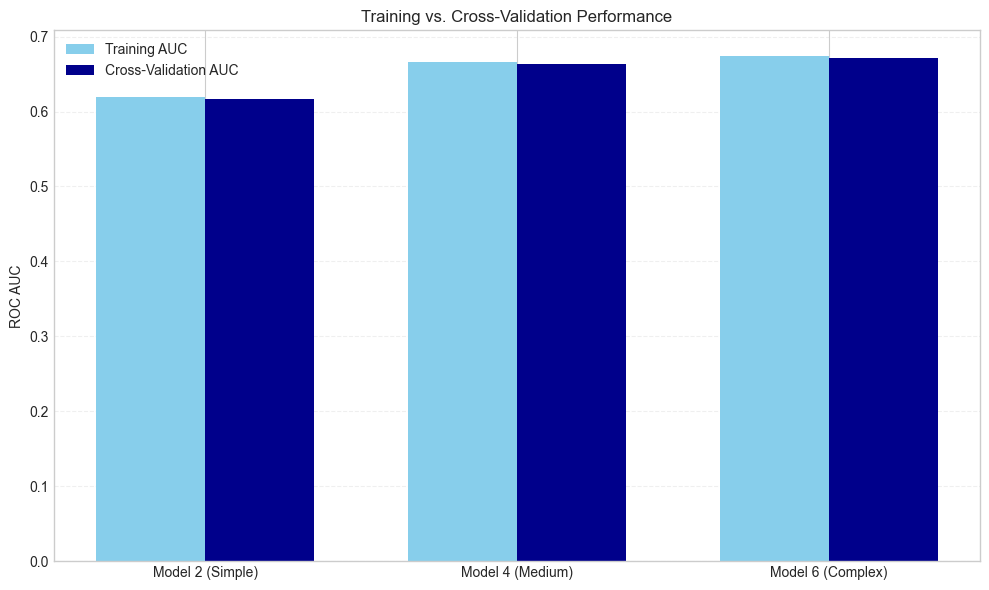

In [66]:
print("\nComparison with training set results:")
print(f"Best model on training set: Model 6 (AUC = {comparison_df.loc[5, 'ROC AUC']:.4f}, Accuracy = {comparison_df.loc[5, 'Accuracy']:.4f})")
print(f"Number of coefficients in best cross-validated model: {cv_results.iloc[best_cv_auc_idx]['Num Coefficients']}")

# Create a visual comparison between training and cross-validation performance
plt.figure(figsize=(12, 6))
models = ['Model 2 (Simple)', 'Model 4 (Medium)', 'Model 6 (Complex)']
train_aucs = [comparison_df.loc[1, 'ROC AUC'], comparison_df.loc[3, 'ROC AUC'], comparison_df.loc[5, 'ROC AUC']]
cv_aucs = [model2_auc_mean, model4_auc_mean, model6_auc_mean]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_aucs, width, label='Training AUC', color='skyblue')
rects2 = ax.bar(x + width/2, cv_aucs, width, label='Cross-Validation AUC', color='darkblue')

ax.set_ylabel('ROC AUC')
ax.set_title('Training vs. Cross-Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()